# **Seattle Micromobility: Collision Analysis**

## **Introduction**
This notebook aims to analyze collision data related to micromobility users in Seattle. By leveraging geospatial analysis techniques, we will identify high-risk zones, examine severity trends, and explore potential correlation  with infrastructure such as bike lanes and sidewalks.

**Dataset Overview**

1. **SDOT Collision Data (All Years)** 
    - Source: [Seattle Open GIS Portal](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::sdot-collisions-all-years/about)
    - Contains traffic collision records with location, severity, and involved road users.

2. **SDOT Bike Facilities Dataset**
    - Source: [ArcGIS Feature Server](https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/SDOT_Bike_Facilities/FeatureServer)
    - Contains Seattle's bike infrastructure, including protected lanes, shared paths, and bike routes.

3. **Seattle Sidewalk Data**
    - Source: [Seattle Open Data](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::sidewalks-1/about)
    - Contains sidewalk network data, including attributes like width, condition, and connectivity.

### **Import Required Libraries**

In [1]:
import pandas as pd
import geopandas as gpd
import requests 
import json
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from sklearn.cluster import DBSCAN
import numpy as np

## **Data Acquisition & Cleaning**

### **Load Collision Dataset**

In [2]:
#API URL with a date filter for 2020 - present (excluding Covid-19 period)
base_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/SDOT_Collisions_All_Years/FeatureServer/0/query"

# Define query parameters
params = {
    "where": "INCDATE >= DATE '2020-01-01'",  # Filtering for data from 2020 onwards
    "outFields": "*",  # Retrieve all columns
    "outSR": "4326",  # Set spatial reference system (WGS 84)
    "f": "geojson",  # Request data in GeoJSON format
    "resultRecordCount": 2000  # Max per request
}

# Initialize an empty list to store data
all_records = []
offset = 0

while True:
    params['resultOffset']=offset
   
    # Encode parameters correctly
    query_url = f"{base_url}?{urllib.parse.urlencode(params)}"
    # Request data
    response = requests.get(query_url)
    
    # Check for errors
    if response.status_code != 200:
        print(f"Error {response.status_code}: Failed to fetch data")
        break
    
    # Convert response to JSON
    data = response.json()

    # Check if there are any records left
    if "features" in data and len(data["features"]) > 0:
        # Convert batch into a GeoDataFrame
        gdf_batch = gpd.GeoDataFrame.from_features(data["features"], crs="EPSG:4326")
        
        # Append to full list
        all_records.append(gdf_batch)
        
        # Increase offset for next batch
        offset += 2000
    else:
        # No more data available, exit loop
        break

# Combine all batches into one GeoDataFrame
if all_records:
    collisions_gdf = pd.concat(all_records, ignore_index=True)
    print(f"✅ Successfully retrieved {len(collisions_gdf)} records!")
    collisions_gdf.info()
else:
    print("⚠️ No data retrieved!")

✅ Successfully retrieved 36838 records!
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36838 entries, 0 to 36837
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 36338 non-null  geometry
 1   OBJECTID                 36838 non-null  int64   
 2   SE_ANNO_CAD_DATA         36838 non-null  object  
 3   INCKEY                   36838 non-null  int64   
 4   COLDETKEY                36838 non-null  int64   
 5   REPORTNO                 36838 non-null  object  
 6   STATUS                   36838 non-null  object  
 7   ADDRTYPE                 36549 non-null  object  
 8   INTKEY                   14822 non-null  float64 
 9   LOCATION                 36454 non-null  object  
 10  EXCEPTRSNCODE            1436 non-null   object  
 11  EXCEPTRSNDESC            1436 non-null   object  
 12  SEVERITYCODE             36838 non-null  object  
 13  SEVERITYDESC 

In [3]:
pd.set_option("display.max_columns", None)
collisions_gdf.sort_values(by="INCDATE", ascending=True).head()

,geometry,OBJECTID,SE_ANNO_CAD_DATA,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,DIAGRAMLINK,REPORTLINK,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCE,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYCD,SHAREDMICROMOBILITYDESC
2779,POINT (-122.40229 47.64954),29907586,,327754,329254,EA00956,Unmatched,Block,NaN,35TH AVE W BETWEEN W DRAVUS ST AND W BERTONA ST,None,None,2,Injury Collision,None,2,0,0,0,1,0,0,1577836800000,1/1/2020,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,PTCR,Police Traffic Collision Report,1579564800000,1.579565e+12,None,None
1185,POINT (-122.29651 47.73015),29905343,,328376,329876,EA09365,Matched,Intersection,36009.0,30TH AVE NE AND NE 140TH ST,None,None,1,Property Damage Only Collision,Angles,5,0,0,2,0,0,0,1577836800000,1/1/2020 3:40:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,N,Clear,Wet,Dark - Street Lights On,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,10,Entering at angle,0,0,N,20-263,PTCR,Police Traffic Collision Report,1580688000000,1.652227e+12,None,None
754,POINT (-122.24658 47.51105),29904480,,327668,329168,3856901,Matched,Intersection,38351.0,CORNELL AVE S AND RAINIER AVE S,None,None,2b,Serious Injury Collision,Other,1,0,0,1,1,1,0,1577836800000,1/1/2020 9:32:00 PM,At Intersection (intersection related),28,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,None,N,Clear,Dry,Dark - Street Lights On,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,50,Fixed object,0,0,N,2020-1061,PTCR,Police Traffic Collision Report,1579132800000,1.652227e+12,None,None
1650,POINT (-122.30033 47.5648),29906191,,327772,329272,3856827,Matched,Block,NaN,CHEASTY BLVD S BETWEEN 25TH AVE S AND 24TH PL S,None,None,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,1577836800000,1/1/2020 4:30:00 AM,Mid-Block (not related to intersection),28,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,None,N,Overcast,Wet,Dark - No Street Lights,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,Y,50,Fixed object,0,0,N,2020-000287,PTCR,Police Traffic Collision Report,1579564800000,1.652227e+12,None,None
1064,POINT (-122.33207 47.61656),29905110,,327935,329435,EA04527,Matched,Block,NaN,BOREN AVE BETWEEN HOWELL ST AND STEWART ST,None,None,2,Injury Collision,Pedestrian,2,1,0,1,1,0,0,1577836800000,1/1/2020 12:52:00 AM,Mid-Block (not related to intersection),24,MOTOR VEHCILE STRUCK PEDESTRIAN,None,N,Clear,Dry,Dark - Street Lights On,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,0,Vehicle going straight hits pedestrian,0,0,N,2020-000089,PTCR,Police Traffic Collision Report,1579737600000,1.652227e+12,None,None


In [4]:
# Convert INCDATE from milliseconds to datetime
collisions_gdf['INCDATE'] = pd.to_datetime(collisions_gdf['INCDATE'], unit='ms')

In [5]:
collisions_gdf.sort_values(by="INCDATE", ascending=False).head()

,geometry,OBJECTID,SE_ANNO_CAD_DATA,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,DIAGRAMLINK,REPORTLINK,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCE,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYCD,SHAREDMICROMOBILITYDESC
27280,POINT (-122.27281 47.54248),29932335,,379386,380906,3931651,Unmatched,Intersection,34420.0,RAINIER AVE S AND S HOLLY ST,None,None,0,Unknown,None,0,0,0,0,0,0,0,2025-02-25,2/25/2025,At Intersection (intersection related),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,PTCR,Police Traffic Collision Report,1740528000000,NaN,U,Unknown
27087,POINT (-122.26638 47.53159),29932142,,379360,380880,EF68465,Unmatched,Intersection,34655.0,SEWARD PARK AVE S AND S KENYON ST,None,None,1,Property Damage Only Collision,None,2,0,0,0,0,0,0,2025-02-23,2/23/2025,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,CVCR,Citizen Vehicle Collision Report,1740441600000,1.740442e+12,U,Unknown
26786,POINT (-122.34326 47.61145),29931841,,379361,380881,EF68466,Unmatched,Block,NaN,1ST AVE BETWEEN VIRGINIA ST AND LENORA ST,NEI,"Not Enough Information, or Insufficient Locati...",0,Unknown,None,2,0,0,0,0,0,0,2025-02-23,2/23/2025,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,CVCR,Citizen Vehicle Collision Report,1740441600000,1.740442e+12,U,Unknown
27663,POINT (-122.3848 47.56287),29932718,,379359,380879,EF68464,Unmatched,Block,NaN,SW OREGON ST BETWEEN 41ST AVE SW AND 42ND AVE SW,None,None,1,Property Damage Only Collision,None,3,0,0,0,0,0,0,2025-02-23,2/23/2025,Mid-Block (but intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,CVCR,Citizen Vehicle Collision Report,1740441600000,1.740442e+12,U,Unknown
27798,POINT (-122.36279 47.56914),29932853,,379381,380901,3926307,Unmatched,Block,NaN,DELRIDGE WAY SW BETWEEN DELRIDGE-W SEATTLE BR ...,None,None,2,Injury Collision,None,2,0,0,0,1,0,0,2025-02-23,2/23/2025,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,None,None,None,None,None,0,0,N,None,PTCR,Police Traffic Collision Report,1740528000000,1.740528e+12,U,Unknown


### **Load SDOT Bike Facilites Dataset**

In [6]:
# Define API URL 
bike_facilities_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/SDOT_Bike_Facilities/FeatureServer/2/query"  # Existing Bike Facilities
multi_use_trails_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/SDOT_Bike_Facilities/FeatureServer/1/query"  # Multi-Use Trails


# Define base query parameters
base_params = {
    "where": "1=1",         # Get all records
    "outFields": "*",       # Retrieve all fields
    "outSR": "4326",        # Spatial reference system (WGS 84)
    "f": "geojson",         # Request format as GeoJSON
    "resultRecordCount": 2000  # Max per request
}
# Function to fetch all records using pagination
def fetch_all_bike_data(url):
    """
    Fetches all records from the API using pagination.
    Returns: GeoDataFrame with all features.
    """
    all_features = []
    offset = 0  # Start at 0

    while True:
        params = base_params.copy()
        params["resultOffset"] = offset  # Offset for pagination

        # Fetch data
        response = requests.get(url, params=params)

        if response.status_code == 200:
            try:
                data = response.json()
                
                if "features" in data and len(data["features"]) > 0:
                    all_features.extend(data["features"])  # Append new records

                    # Stop when no more records to retrieve
                    if len(data["features"]) < 2000:
                        break
                else:
                    print(f"⚠️ Warning: No more data returned from {url}")
                    break
            except json.JSONDecodeError:
                print(f"❌ Error: Unable to parse API response from {url}")
                break
        else:
            print(f"❌ Failed to fetch data - HTTP Status Code: {response.status_code}")
            break
        
        offset += 2000  # Move to next batch

    # Convert to GeoDataFrame if data exists
    if all_features:
        gdf = gpd.GeoDataFrame.from_features(all_features)
        gdf.set_crs(epsg=4326, inplace=True)  # Ensure CRS consistency
        return gdf
    else:
        return None

# Fetch both datasets
bike_facilities_gdf = fetch_all_bike_data(bike_facilities_url)
multi_use_trails_gdf = fetch_all_bike_data(multi_use_trails_url)

In [7]:
bike_facilities_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   geometry                      3540 non-null   geometry
 1   OBJECTID                      3540 non-null   int64   
 2   COMPKEY                       3540 non-null   int64   
 3   COMPTYPE                      3540 non-null   int64   
 4   SEGKEY                        3540 non-null   int64   
 5   UNITID                        3540 non-null   object  
 6   UNITTYPE                      3540 non-null   object  
 7   UNITDESC                      3540 non-null   object  
 8   CATEGORY                      3529 non-null   object  
 9   MATERIAL                      102 non-null    object  
 10  STYLE                         541 non-null    object  
 11  MODEL_TYPE                    2637 non-null   object  
 12  ASSET_WIDTH                   3540 non-n

In [8]:
bike_facilities_gdf.sort_values(by="CURRENT_STATUS_DATE", ascending=False).head()

,geometry,OBJECTID,COMPKEY,COMPTYPE,SEGKEY,UNITID,UNITTYPE,UNITDESC,CATEGORY,MATERIAL,STYLE,MODEL_TYPE,ASSET_WIDTH,ASSET_HEIGHT,INSTALL_DATE,ASBLT,ATTACHMENT_1,ATTACHMENT_2,ATTACHMENT_3,ATTACHMENT_4,ATTACHMENT_5,ATTACHMENT_6,ATTACHMENT_7,ATTACHMENT_8,ATTACHMENT_9,ATTACHMENT_10,NUM_ATTACHMENTS,COMMENTS,CURRENT_STATUS,CURRENT_STATUS_DATE,CONDITION,CONDITION_ASSESSMENT_DATE,LAST_ASSET_VERIFICATION_DATE,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,OVERRIDEYN,OVERRIDECOMMENT,OWNERSHIP,OWNERSHIP_DATE,MAINTAINED_BY,MAINTENANCE_AGREEMENT,MAINTENANCE_FINANCIAL_RESP,ADDBY,ADDDTTM,MODBY,MODDTTM,DATE_MVW_LAST_UPDATED,COLOR,MOUNT_TYPE,MOUNT_MATERIAL,EXPBY,EXPDATE,MAINT_GRP_PAINT,MAINT_GRP_PLANTS,MAINT_GRP_POST,MAINT_GRP_SNOW,MAINT_GRP_SWEEP,Shape__Length
460,"LINESTRING (-122.33946 47.60531, -122.3401 47....",1784479,916182,16,8722,BKF-7881,BKF,ALASKAN WAY BETWEEN SENECA ST AND UNIVERSITY S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,1.738282e+12,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,309.049254
898,"LINESTRING (-122.33639 47.60172, -122.33696 47...",1784917,916177,16,8717,BKF-7876,BKF,ALASKAN WR WAY BETWEEN YESLER WAY AND COLUMBIA...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,1.738282e+12,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,291.269208
3086,"LINESTRING (-122.33759 47.60314, -122.33824 47...",1787105,916179,16,8719,BKF-7878,BKF,ALASKAN WR WAY BETWEEN MARION ST AND MADISON S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,1.738282e+12,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,308.096397
1079,"LINESTRING (-122.33823 47.60386, -122.3388 47....",1785098,916180,16,8720,BKF-7879,BKF,ALASKAN WR WAY BETWEEN MADISON ST AND SPRING S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,1.738282e+12,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,311.868483
1496,"LINESTRING (-122.34101 47.60704, -122.3401 47....",1785515,916183,16,8723,BKF-7882,BKF,ALASKAN WAY BETWEEN UNIVERSITY ST AND UNION ST...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,1.738282e+12,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,426.032332


In [9]:
bike_facilities_gdf["CURRENT_STATUS_DATE"] = pd.to_datetime(bike_facilities_gdf["CURRENT_STATUS_DATE"], unit="ms")

In [10]:
bike_facilities_gdf.sort_values(by="CURRENT_STATUS_DATE", ascending=False).head()

,geometry,OBJECTID,COMPKEY,COMPTYPE,SEGKEY,UNITID,UNITTYPE,UNITDESC,CATEGORY,MATERIAL,STYLE,MODEL_TYPE,ASSET_WIDTH,ASSET_HEIGHT,INSTALL_DATE,ASBLT,ATTACHMENT_1,ATTACHMENT_2,ATTACHMENT_3,ATTACHMENT_4,ATTACHMENT_5,ATTACHMENT_6,ATTACHMENT_7,ATTACHMENT_8,ATTACHMENT_9,ATTACHMENT_10,NUM_ATTACHMENTS,COMMENTS,CURRENT_STATUS,CURRENT_STATUS_DATE,CONDITION,CONDITION_ASSESSMENT_DATE,LAST_ASSET_VERIFICATION_DATE,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,OVERRIDEYN,OVERRIDECOMMENT,OWNERSHIP,OWNERSHIP_DATE,MAINTAINED_BY,MAINTENANCE_AGREEMENT,MAINTENANCE_FINANCIAL_RESP,ADDBY,ADDDTTM,MODBY,MODDTTM,DATE_MVW_LAST_UPDATED,COLOR,MOUNT_TYPE,MOUNT_MATERIAL,EXPBY,EXPDATE,MAINT_GRP_PAINT,MAINT_GRP_PLANTS,MAINT_GRP_POST,MAINT_GRP_SNOW,MAINT_GRP_SWEEP,Shape__Length
898,"LINESTRING (-122.33639 47.60172, -122.33696 47...",1784917,916177,16,8717,BKF-7876,BKF,ALASKAN WR WAY BETWEEN YESLER WAY AND COLUMBIA...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,2025-01-31,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,291.269208
1079,"LINESTRING (-122.33823 47.60386, -122.3388 47....",1785098,916180,16,8720,BKF-7879,BKF,ALASKAN WR WAY BETWEEN MADISON ST AND SPRING S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,2025-01-31,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,311.868483
3085,"LINESTRING (-122.33758 47.60314, -122.33824 47...",1787104,916179,16,8719,BKF-7878,BKF,ALASKAN WR WAY BETWEEN MARION ST AND MADISON S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,2025-01-31,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,307.011461
3086,"LINESTRING (-122.33759 47.60314, -122.33824 47...",1787105,916179,16,8719,BKF-7878,BKF,ALASKAN WR WAY BETWEEN MARION ST AND MADISON S...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,2025-01-31,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,308.096397
3509,"LINESTRING (-122.33696 47.60242, -122.33759 47...",1787528,916178,16,8718,BKF-7877,BKF,ALASKAN WR WAY BETWEEN COLUMBIA ST AND MARION ...,BKF-PBL,None,BKF-LSCP,BKF-TWOWAY,11.0,0,1.738282e+12,None,None,None,None,None,None,None,None,None,None,None,0,None,INSVC,2025-01-31,None,NaN,1.738282e+12,DISTRICT7,None,N,None,None,NaN,None,None,None,LYNCHC,1738022400000,LYNCHC,1.738022e+12,1740683710000,None,None,None,None,None,None,None,None,None,None,305.250003


In [11]:
multi_use_trails_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   geometry           203 non-null    geometry
 1   OBJECTID           203 non-null    int64   
 2   SE_ANNO_CAD_DATA   203 non-null    object  
 3   F_INTR_ID          203 non-null    int64   
 4   T_INTR_ID          203 non-null    int64   
 5   SND_ID             203 non-null    int64   
 6   SND_FEACODE        203 non-null    int64   
 7   CITYCODE           203 non-null    int64   
 8   STNAME_ID          203 non-null    int64   
 9   ST_CODE            203 non-null    int64   
 10  ARTERIAL_CODE      203 non-null    int64   
 11  SEGMENT_TYPE       203 non-null    int64   
 12  AGENCY_CODE        203 non-null    int64   
 13  ACCESS_CODE        203 non-null    int64   
 14  DIVIDED_CODE       203 non-null    int64   
 15  STRUCTURE_TYPE     203 non-null    int64   
 16  

In [12]:
multi_use_trails_gdf.head()

,geometry,OBJECTID,SE_ANNO_CAD_DATA,F_INTR_ID,T_INTR_ID,SND_ID,SND_FEACODE,CITYCODE,STNAME_ID,ST_CODE,ARTERIAL_CODE,SEGMENT_TYPE,AGENCY_CODE,ACCESS_CODE,DIVIDED_CODE,STRUCTURE_TYPE,LEGALLOC_CODE,VEHICLE_USE_CODE,GIS_SEG_LENGTH,L_ADRS_FROM,L_ADRS_TO,R_ADRS_FROM,R_ADRS_TO,ORD_PRE_DIR,ORD_STREET_NAME,ORD_STREET_TYPE,ORD_SUF_DIR,ORD_STNAME_CONCAT,L_CITY,L_STATE,L_ZIP,R_CITY,R_STATE,R_ZIP,SNDSEG_UPDATE,COMPKEY,COMPTYPE,UNITID,UNITID2,Shape__Length
0,"LINESTRING (-122.38328 47.64201, -122.38252 47...",80623,,9419,9425,47185,77,1,3053,22,0,8,1,1,1,1,3,2,324.0,0,0,0,0,None,ELLIOTT BAY,TRL,None,ELLIOTT BAY TRL,SEATTLE,WA,98119,SEATTLE,WA,98119,1500552687000,287058,68,06561,0250,324.057273
1,"LINESTRING (-122.36406 47.65245, -122.36516 47...",80624,,8635,8286,15985,77,1,3297,22,0,8,1,1,1,1,3,2,2152.0,0,0,0,0,None,SHIP CANAL,TRL,None,SHIP CANAL TRL,SEATTLE,WA,98119,SEATTLE,WA,98119,1500552690000,538894,68,09667,0060,2152.092140
2,"LINESTRING (-122.37669 47.65479, -122.37673 47...",80625,,47267,8460,48316,77,1,3297,22,0,8,1,1,1,1,3,2,524.0,0,0,0,0,None,SHIP CANAL,TRL,None,SHIP CANAL TRL,SEATTLE,WA,98119,SEATTLE,WA,98119,1500552682000,287090,68,09667,0160,523.764057
3,"LINESTRING (-122.36101 47.57089, -122.36123 47...",80626,,14569,14669,43194,77,1,3815,22,0,8,1,1,1,1,3,2,366.0,0,0,0,0,None,DELRIDGE CONNCTR,TRL,None,DELRIDGE CONNCTR TRL,SEATTLE,WA,98106,SEATTLE,WA,98106,1500552463000,286981,68,06318,0220,365.719129
4,"LINESTRING (-122.35152 47.56116, -122.35156 47...",80627,,15328,15124,27982,77,1,3040,22,0,8,1,1,1,1,3,2,1158.0,0,0,0,0,None,DUWAMISH RIVER,TRL,None,DUWAMISH RIVER TRL,SEATTLE,WA,98106,SEATTLE,WA,98106,1500453972000,286965,68,06487,0420,1157.886755


### **Load SDOT Sidewalks Dataset**

In [13]:
# API URL for Seattle Sidewalks Dataset 
sidewalks_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/Sidewalks_CDL/FeatureServer/0/query"

# Define parameters for API request
params = {
    "where": "CURRENT_STATUS = 'INSVC'",  # filter only INSVC (in service) 
    "outFields": "*",  # Get all fields
    "outSR": "4326",  # Set spatial reference to WGS84
    "f": "geojson"  # Request response in GeoJSON format
}

# Initialize an empty list to store data
all_records = []
offset = 0

while True:
    params['resultOffset']=offset
   
    # Encode parameters correctly
    query_url = f"{sidewalks_url}?{urllib.parse.urlencode(params)}"
    # Request data
    response = requests.get(query_url)
    
    # Check for errors
    if response.status_code != 200:
        print(f"Error {response.status_code}: Failed to fetch data")
        break
    
    # Convert response to JSON
    data = response.json()

    # Check if there are any records left
    if "features" in data and len(data["features"]) > 0:
        # Convert batch into a GeoDataFrame
        gdf_batch = gpd.GeoDataFrame.from_features(data["features"], crs="EPSG:4326")
        
        # Append to full list
        all_records.append(gdf_batch)
        
        # Increase offset for next batch
        offset += 2000
    else:
        # No more data available, exit loop
        break

# Combine all batches into one GeoDataFrame
if all_records:
    sidewalks_gdf = pd.concat(all_records, ignore_index=True)
    print(f"✅ Successfully retrieved {len(sidewalks_gdf)} records!")
    sidewalks_gdf.info()
else:
    print("⚠️ No data retrieved!")


✅ Successfully retrieved 46176 records!
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46176 entries, 0 to 46175
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   46081 non-null  geometry
 1   OBJECTID                   46176 non-null  int64   
 2   COMPKEY                    46176 non-null  int64   
 3   COMPTYPE                   46176 non-null  int64   
 4   SEGKEY                     46176 non-null  int64   
 5   UNITID                     46176 non-null  object  
 6   UNITTYPE                   46176 non-null  object  
 7   UNITDESC                   46176 non-null  object  
 8   ADDDTTM                    46176 non-null  int64   
 9   ASBLT                      1456 non-null   object  
 10  CONDITION                  34687 non-null  object  
 11  CONDITION_ASSESSMENT_DATE  34780 non-null  float64 
 12  CURBTYPE                   45422 non-nul

In [14]:
sidewalks_gdf["CURRENT_STATUS_DATE"] = pd.to_datetime(sidewalks_gdf["CURRENT_STATUS_DATE"], unit="ms")

In [15]:
sidewalks_gdf.sort_values(by="CURRENT_STATUS_DATE", ascending=False).head()

,geometry,OBJECTID,COMPKEY,COMPTYPE,SEGKEY,UNITID,UNITTYPE,UNITDESC,ADDDTTM,ASBLT,CONDITION,CONDITION_ASSESSMENT_DATE,CURBTYPE,CURRENT_STATUS,CURRENT_STATUS_DATE,FILLERTYPE,FILLERWID,INSTALL_DATE,SW_WIDTH,MAINTAINED_BY,MATL,MODDTTM,OWNERSHIP,SIDE,SURFTYPE,BUILDERCD,GSITYPECD,HANSEN7ID,ATTACHMENT_1,ATTACHMENT_2,ATTACHMENT_3,ATTACHMENT_4,ATTACHMENT_5,ATTACHMENT_6,ATTACHMENT_7,ATTACHMENT_8,ATTACHMENT_9,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,OVERRIDEYN,OVERRIDECOMMENT,SRTS_SIDEWALK_RANK,NUM_ATTACHMENTS,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,SW_CATEGORY,MAINTENANCE_GROUP,LAST_VERIFY_DATE,COLOR,OWNERSHIP_DATE,NATURE_OF_MAINT_RESP,MAINT_FINANCIAL_RESP,VARIABLEWIDTHYN,MAINTBYRDWYSTRUCTYN,SWINCOMPLETEYN,MULTIPLESURFACEYN,DATE_MVW_LAST_UPDATED,EXPDATE,Shape__Length
7584,"LINESTRING (-122.34349 47.65809, -122.34345 47...",15910180,295948,97,15470,SDW-6933,SDW,N 42ND ST BETWEEN MIDVALE AVE N AND STONE WAY ...,1190764800000,792-719,EXCELLENT,1.740614e+12,410C,INSVC,2025-02-27,LSCP,96.0,1.735690e+12,72.0,None,None,1.740614e+12,None,N,PCC,PRIDEV,None,120800120N,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,None,None,None,None,None,DISTRICT4,None,N,None,1.0,4,1.5,0,BLOCK,SSRP_NW4_SWShim,1.740614e+12,None,NaN,None,None,N,N,N,N,1740683424000,None,264.033413
122,"LINESTRING (-122.3435 47.6426, -122.34334 47.6...",15902674,917443,97,13547,SDW-47017,SDW,WESTLAKE AVE N BETWEEN HALLADAY ST AND NEWELL ...,1740614400000,None,GOOD,NaN,None,INSVC,2025-02-27,None,NaN,1.740355e+12,NaN,None,None,1.740614e+12,None,NE,PCC,None,None,None,None,None,None,None,None,None,None,None,None,DISTRICT7,None,N,None,3.0,0,0.0,0,TRPLATFM,None,NaN,None,NaN,None,None,N,N,N,N,1740683424000,None,79.559456
38992,"LINESTRING (-122.32817 47.52305, -122.32817 47...",15941594,330957,97,7388,SDW-32859,SDW,5TH AVE S BETWEEN S HENDERSON ST AND S DIRECTO...,1190764800000,794-84,EXCELLENT,1.740614e+12,410B,INSVC,2025-02-27,LSCP,36.0,1.735690e+12,0.0,None,None,1.740614e+12,None,E,PCC,PRIDEV,None,039050900E,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,None,None,None,None,None,None,None,None,DISTRICT1,None,N,None,1.0,1,1.5,48,BLOCK,None,1.740614e+12,None,NaN,None,None,Y,N,N,N,1740683424000,None,269.693454
29066,"LINESTRING (-122.30619 47.59312, -122.30472 47...",15931662,317727,97,20947,SDW-24084,SDW,"S NORMAN ST BETWEEN 20TH AVE S AND 21ST AVE S,...",1190764800000,None,GOOD,1.692576e+12,410C,INSVC,2025-02-18,LSCP,68.0,NaN,72.0,None,None,1.739837e+12,None,N,PCC-TS,SSRP,None,166750200N,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,None,None,None,DISTRICT3,None,N,None,0.0,6,0.6,48,BLOCK,SSRP_C1_SWShim,1.692576e+12,None,NaN,None,None,Y,N,N,N,1740683424000,None,425.291008
1444,"LINESTRING (-122.35774 47.653, -122.35774 47.6...",15904039,288945,97,1115,SDW-35,SDW,1ST AVE NW BETWEEN NW 36TH ST AND NW 39TH W ST...,1190764800000,792-491,EXCELLENT,1.739837e+12,410B,INSVC,2025-02-18,LSCP,144.0,1.735690e+12,72.0,None,None,1.739837e+12,None,W,PCC,PRIDEV,None,000250360W,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\ATTACHMENTS\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,\\dotnas\InfoPublicSector\H8\PROD\Attachments\...,None,None,None,DISTRICT6,None,N,None,1.0,6,1.5,0,BLOCK,SSRP_NW3_SWShim,1.739837e+12,None,NaN,None,None,N,N,N,N,1740683424000,None,405.346508


In [16]:
# Check CRS for each dataset
collisions_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
bike_facilities_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
multi_use_trails_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
sidewalks_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### **Drop Unnecessary Columns and handle missing data**

#### **Drop Unncessary Columns**

In [20]:
# Check the values in each coloumn to decide wheter to drop or not
for col in collisions_gdf.columns:
    print(f"Column: {col}")
    print(collisions_gdf[col].unique()[:10])  # Show only first 10 unique values
    print("-" * 40)

Column: geometry
<GeometryArray>
[<POINT (-122.307 47.621)>, <POINT (-122.326 47.617)>,
 <POINT (-122.295 47.543)>, <POINT (-122.321 47.539)>,
 <POINT (-122.296 47.599)>,  <POINT (-122.27 47.517)>,
 <POINT (-122.347 47.572)>,  <POINT (-122.348 47.62)>,
 <POINT (-122.333 47.606)>, <POINT (-122.302 47.621)>]
Length: 10, dtype: geometry
----------------------------------------
Column: OBJECTID
[29688071 29688076 29688079 29688081 29688082 29688088 29688091 29688097
 29688108 29688109]
----------------------------------------
Column: SE_ANNO_CAD_DATA
['']
----------------------------------------
Column: INCKEY
[363241 372090 363283 371976 363360 374871 372046 363255 374967 363396]
----------------------------------------
Column: COLDETKEY
[364721 373570 364763 373456 364840 376391 373526 364735 376487 364876]
----------------------------------------
Column: REPORTNO
['ED43421' '3908368' 'ED37228' 'EE69604' '3902848' 'EE74035' '3892837'
 'ED36773' 'EE77710' 'ED38504']
----------------------

In [21]:
#Check in the detail of each column in metadata from ArcGIS

#Define columns to drop
columns_to_drop = [
    "OBJECTID", "SE_ANNO_CAD_DATA", "INCKEY", "COLDETKEY", "REPORTNO",
    "EXCEPTRSNCODE", "SDOTCOLNUM", "SOURCE", "DIAGRAMLINK",
    "REPORTLINK"
]
collisions_gdf_cleaned = collisions_gdf.drop(columns=columns_to_drop)
collisions_gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36838 entries, 0 to 36837
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   geometry                 36338 non-null  geometry      
 1   STATUS                   36838 non-null  object        
 2   ADDRTYPE                 36549 non-null  object        
 3   INTKEY                   14822 non-null  float64       
 4   LOCATION                 36454 non-null  object        
 5   EXCEPTRSNDESC            1436 non-null   object        
 6   SEVERITYCODE             36838 non-null  object        
 7   SEVERITYDESC             36838 non-null  object        
 8   COLLISIONTYPE            27205 non-null  object        
 9   PERSONCOUNT              36838 non-null  int64         
 10  PEDCOUNT                 36838 non-null  int64         
 11  PEDCYLCOUNT              36838 non-null  int64         
 12  VEHCOUNT                

In [22]:
for col in bike_facilities_gdf.columns:
    print(f"Column: {col}")
    print(bike_facilities_gdf[col].unique()[:10])  # Show only first 10 unique values
    print("-" * 40)

Column: geometry
<GeometryArray>
[<LINESTRING (-122.382 47.59, -122.381 47.589, -122.381 47.589, -122.38 47.58...>,
                                  <LINESTRING (-122.316 47.676, -122.314 47.676)>,
 <LINESTRING (-122.278 47.526, -122.278 47.526, -122.277 47.526, -122.277 47....>,
                                   <LINESTRING (-122.304 47.56, -122.304 47.558)>,
                                  <LINESTRING (-122.342 47.661, -122.341 47.661)>,
                                    <LINESTRING (-122.34 47.621, -122.34 47.622)>,
 <LINESTRING (-122.373 47.545, -122.373 47.545, -122.373 47.545, -122.374 47....>,
                                    <LINESTRING (-122.288 47.57, -122.287 47.57)>,
                                  <LINESTRING (-122.315 47.665, -122.315 47.666)>,
 <LINESTRING (-122.328 47.618, -122.328 47.619, -122.328 47.62, -122.328 47.6...>]
Length: 10, dtype: geometry
----------------------------------------
Column: OBJECTID
[1784019 1784020 1784021 1784022 1784023 1784024 17

In [23]:
#Check in the detail of each column in metadata from ArcGIS

#Define columns to drop
columns_to_drop = [
    "OBJECTID", "COMPKEY", "COMPTYPE", "SEGKEY", "UNITTYPE",
    "ASSET_HEIGHT", "ATTACHMENT_1", "ATTACHMENT_2", "ATTACHMENT_3",
    "ATTACHMENT_4", "ATTACHMENT_5", "ATTACHMENT_6", "ATTACHMENT_7",
    "ATTACHMENT_8", "ATTACHMENT_9", "ATTACHMENT_10", "NUM_ATTACHMENTS",
    "OVERRIDEYN", "OVERRIDECOMMENT", "OWNERSHIP", "OWNERSHIP_DATE",
    "MAINTAINED_BY", "MAINTENANCE_AGREEMENT", "MAINTENANCE_FINANCIAL_RESP",
    "ADDBY", "ADDDTTM", "MODBY", "MODDTTM", "EXPBY", "EXPDATE", "MAINT_GRP_PAINT",
    "MAINT_GRP_PLANTS", "MAINT_GRP_POST", "MAINT_GRP_SNOW"
    
]
bike_facilities_gdf_cleaned = bike_facilities_gdf.drop(columns=columns_to_drop)
bike_facilities_gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   geometry                      3540 non-null   geometry      
 1   UNITID                        3540 non-null   object        
 2   UNITDESC                      3540 non-null   object        
 3   CATEGORY                      3529 non-null   object        
 4   MATERIAL                      102 non-null    object        
 5   STYLE                         541 non-null    object        
 6   MODEL_TYPE                    2637 non-null   object        
 7   ASSET_WIDTH                   3540 non-null   float64       
 8   INSTALL_DATE                  3308 non-null   float64       
 9   ASBLT                         68 non-null     object        
 10  COMMENTS                      1768 non-null   object        
 11  CURRENT_STATUS        

In [24]:
for col in multi_use_trails_gdf.columns:
    print(f"Column: {col}")
    print(multi_use_trails_gdf[col].unique()[:10])  # Show only first 10 unique values
    print("-" * 40)

Column: geometry
<GeometryArray>
[                <LINESTRING (-122.383 47.642, -122.383 47.642, -122.382 47.642)>,
 <LINESTRING (-122.364 47.652, -122.365 47.653, -122.366 47.653, -122.366 47....>,
 <LINESTRING (-122.377 47.655, -122.377 47.655, -122.377 47.655, -122.377 47....>,
 <LINESTRING (-122.361 47.571, -122.361 47.571, -122.361 47.571, -122.361 47....>,
 <LINESTRING (-122.352 47.561, -122.352 47.562, -122.352 47.564, -122.353 47....>,
 <LINESTRING (-122.385 47.595, -122.385 47.595, -122.385 47.595, -122.386 47....>,
 <LINESTRING (-122.328 47.626, -122.328 47.626, -122.328 47.626, -122.328 47....>,
 <LINESTRING (-122.294 47.546, -122.294 47.546, -122.294 47.546, -122.294 47....>,
 <LINESTRING (-122.292 47.544, -122.292 47.543, -122.292 47.543, -122.292 47....>,
 <LINESTRING (-122.279 47.526, -122.279 47.526, -122.279 47.526, -122.279 47....>]
Length: 10, dtype: geometry
----------------------------------------
Column: OBJECTID
[80623 80624 80625 80626 80627 80628 80629 80630 80

In [25]:
#Check in the detail of each column in metadata from ArcGIS

#Define columns to drop
columns_to_drop = [
    "OBJECTID", "SE_ANNO_CAD_DATA", "F_INTR_ID", "T_INTR_ID", "SND_ID",
    "SND_FEACODE", "CITYCODE", "ST_CODE", "ARTERIAL_CODE",
    "SEGMENT_TYPE", "DIVIDED_CODE", "VEHICLE_USE_CODE", "L_CITY",
    "L_STATE", "R_CITY", "R_STATE", "COMPKEY",
    "COMPTYPE"
]
multi_use_trails_gdf_cleaned = multi_use_trails_gdf.drop(columns=columns_to_drop)
multi_use_trails_gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   geometry           203 non-null    geometry
 1   STNAME_ID          203 non-null    int64   
 2   AGENCY_CODE        203 non-null    int64   
 3   ACCESS_CODE        203 non-null    int64   
 4   STRUCTURE_TYPE     203 non-null    int64   
 5   LEGALLOC_CODE      203 non-null    int64   
 6   GIS_SEG_LENGTH     203 non-null    float64 
 7   L_ADRS_FROM        203 non-null    int64   
 8   L_ADRS_TO          203 non-null    int64   
 9   R_ADRS_FROM        203 non-null    int64   
 10  R_ADRS_TO          203 non-null    int64   
 11  ORD_PRE_DIR        1 non-null      object  
 12  ORD_STREET_NAME    203 non-null    object  
 13  ORD_STREET_TYPE    202 non-null    object  
 14  ORD_SUF_DIR        9 non-null      object  
 15  ORD_STNAME_CONCAT  203 non-null    object  
 16  

In [26]:
# Check the values in each coloumn to decide wheter to drop or not
for col in sidewalks_gdf.columns:
    print(f"Column: {col}")
    print(sidewalks_gdf[col].unique()[:10])  # Show only first 10 unique values
    print("-" * 40)

Column: geometry
<GeometryArray>
[                                 <LINESTRING (-122.317 47.677, -122.317 47.677)>,
                                  <LINESTRING (-122.309 47.728, -122.307 47.728)>,
 <LINESTRING (-122.352 47.558, -122.353 47.558, -122.353 47.558, -122.353 47....>,
                                   <LINESTRING (-122.29 47.555, -122.289 47.553)>,
                                  <LINESTRING (-122.306 47.725, -122.305 47.725)>,
 <LINESTRING (-122.361 47.571, -122.361 47.571, -122.361 47.571, -122.361 47....>,
                                  <LINESTRING (-122.256 47.515, -122.254 47.514)>,
 <LINESTRING (-122.404 47.642, -122.404 47.642, -122.404 47.642, -122.404 47....>,
 <LINESTRING (-122.334 47.548, -122.334 47.548, -122.334 47.545, -122.334 47....>,
                                  <LINESTRING (-122.303 47.727, -122.302 47.727)>]
Length: 10, dtype: geometry
----------------------------------------
Column: OBJECTID
[15902537 15902538 15902539 15902540 15902541 15902

In [27]:
#Check in the detail of each column in metadata from ArcGIS

#Define columns to drop
columns_to_drop = [
    "OBJECTID", "COMPKEY", "COMPTYPE", "SEGKEY", "UNITTYPE",
    "MATL", "GSITYPECD", "HANSEN7ID", "ATTACHMENT_3",
    "ATTACHMENT_4", "ATTACHMENT_5", "ATTACHMENT_6", "ATTACHMENT_7",
    "ATTACHMENT_8", "ATTACHMENT_9", "ATTACHMENT_1", "ATTACHMENT_2",
    "NUM_ATTACHMENTS", "OVERRIDEYN", "OVERRIDECOMMENT", "COLOR", 
    "NATURE_OF_MAINT_RESP", "MAINTBYRDWYSTRUCTYN", "MAINT_FINANCIAL_RESP",
    "EXPDATE"
]
sidewalks_gdf_cleaned = sidewalks_gdf.drop(columns=columns_to_drop)
sidewalks_gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46176 entries, 0 to 46175
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   geometry                   46081 non-null  geometry      
 1   UNITID                     46176 non-null  object        
 2   UNITDESC                   46176 non-null  object        
 3   ADDDTTM                    46176 non-null  int64         
 4   ASBLT                      1456 non-null   object        
 5   CONDITION                  34687 non-null  object        
 6   CONDITION_ASSESSMENT_DATE  34780 non-null  float64       
 7   CURBTYPE                   45422 non-null  object        
 8   CURRENT_STATUS             46176 non-null  object        
 9   CURRENT_STATUS_DATE        35999 non-null  datetime64[ns]
 10  FILLERTYPE                 45507 non-null  object        
 11  FILLERWID                  46145 non-null  float64       
 

#### **Handle Missing Values**

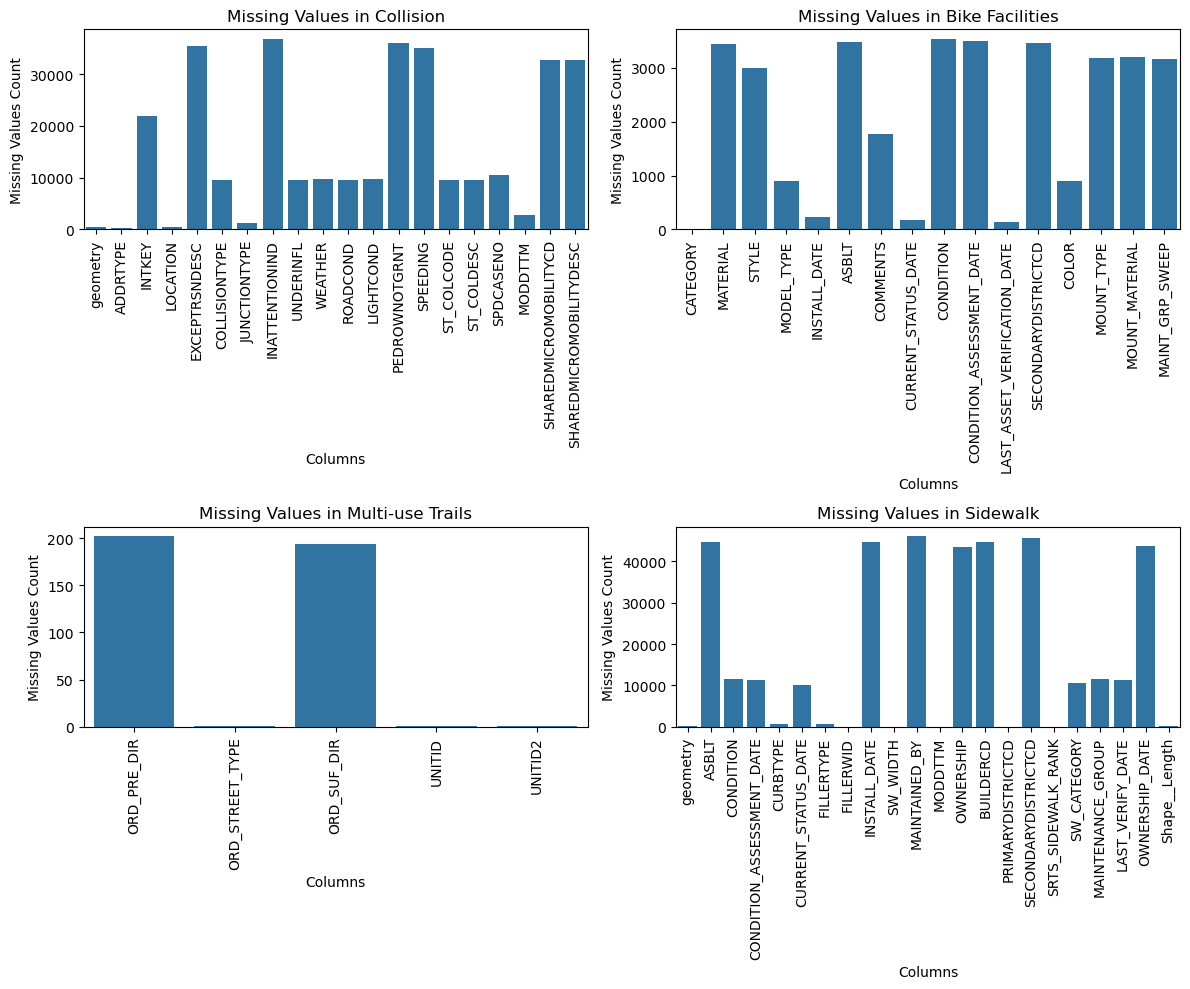

In [28]:
#Check for missing values by plotting a histogram

def plot_missing_values(dfs, titles):
    fig, axs = plt.subplots(2,2,figsize=(12,10))
    axs = axs.flatten()

    for i, (df,title) in enumerate(zip(dfs, titles)):
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0]

        if not missing_values.empty:
            sns.barplot(x=missing_values.index, y=missing_values.values, ax=axs[i])
            axs[i].set_xticks(range(len(missing_values)))
            axs[i].set_xticklabels(missing_values.index, rotation=90)
            axs[i].set_ylabel('Missing Values Count')
            axs[i].set_xlabel('Columns')
            axs[i].set_title(f'Missing Values in {title}')
        else:
            axs[i].axis('off')  # Hide empty plots 

    plt.tight_layout()
    plt.show()

dfs = [collisions_gdf_cleaned, bike_facilities_gdf_cleaned, multi_use_trails_gdf_cleaned, sidewalks_gdf_cleaned]
titles = ['Collision','Bike Facilities', 'Multi-use Trails','Sidewalk']

plot_missing_values(dfs,titles)


In [29]:
#Check the columns that have more than 50% missing value whether to drop or fill in the data

missing_percentage = (collisions_gdf_cleaned.isnull().sum() / len(collisions_gdf_cleaned)) * 100
missing_percentage = missing_percentage[missing_percentage > 80].sort_values(ascending=False)

# Display columns with missing data
print("⚠️ Missing Data in Collision Dataset:")
print(missing_percentage)

⚠️ Missing Data in Collision Dataset:
INATTENTIONIND             100.000000
PEDROWNOTGRNT               97.809327
EXCEPTRSNDESC               96.101851
SPEEDING                    95.344481
SHAREDMICROMOBILITYCD       89.079212
SHAREDMICROMOBILITYDESC     89.079212
dtype: float64


In [30]:
collisions_gdf_cleaned['SHAREDMICROMOBILITYDESC'].unique()

array([None, 'Unknown', 'Yes, Shared Micro Mobility was involved',
       'No, Shared Micro Mobility was not involved'], dtype=object)

In [31]:
collisions_gdf_cleaned['SPEEDING'].unique()

array([None, 'Y'], dtype=object)

From the metadata of Collision dataset,

- INATTENTIONIND: Whether or not collision was due to inattention.
(Y/N)
- PEDROWNOTGRNT: Whether or not the pedestrian right of way was
not granted. (Y/N)
- EXCEPTRSNDESC: Cannot find the detail information
- SPEEDING: Whether or not speeding was a factor in the
collision. (Y/N)
- SHAREDMICROMOBILITYCD: the abbreviation of SHAREDMICROMOBILITYDESC
- SHAREDMICROMOBILITYDESC: the description about micor moblity sharing 
- INTKEY: Key that corresponds to the intersection
associated with a collision

**Drop Columns: INATTENTIONIND, EXCEPTRSNDESC,SHAREDMICROMOBILITYCD**


In [32]:
collisions_gdf_cleaned = collisions_gdf_cleaned.drop(columns=['INATTENTIONIND', 'EXCEPTRSNDESC', 'SHAREDMICROMOBILITYCD'])

In [33]:
collisions_gdf_cleaned

,geometry,STATUS,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYDESC
0,POINT (-122.30734 47.62128),Matched,Block,NaN,19TH AVE E BETWEEN E THOMAS ST AND E HARRISON ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2023-03-02,3/2/2023 8:38:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Overcast,Wet,Daylight,None,None,19,One car entering parked position,0,0,N,2023-58369,Police Traffic Collision Report,1689033600000,1.689638e+12,None
1,POINT (-122.32555 47.61704),Unmatched,Block,NaN,SUMMIT AVE BETWEEN E OLIVE ST AND E HOWELL W ST,0,Unknown,None,2,0,0,0,0,0,0,2024-05-26,5/26/2024,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,1716940800000,1.716941e+12,None
2,POINT (-122.29475 47.54265),Matched,Intersection,34329.0,SHAFFER AVE S AND S HOLLY ST,2,Injury Collision,Angles,6,0,0,3,1,0,0,2023-02-10,2/10/2023 3:55:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,10,Entering at angle,0,0,N,2023-39444,Police Traffic Collision Report,1689120000000,1.689638e+12,None
3,POINT (-122.32127 47.53904),Unmatched,Block,NaN,EAST MARGINAL WAY S BETWEEN S MYRTLE ST AND EL...,1,Property Damage Only Collision,None,1,0,0,0,0,0,0,2024-04-18,4/18/2024,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,1716336000000,1.716336e+12,None
4,POINT (-122.29623 47.59922),Matched,Intersection,30603.0,28TH AVE S AND S JACKSON ST,1,Property Damage Only Collision,Cycles,2,0,1,1,0,0,0,2023-07-10,7/10/2023 8:01:00 PM,At Intersection (intersection related),93,"MOTOR VEHICLE STRUCK MOTORIZED SCOOTER, FRONT ...",N,Clear,Dry,Daylight,None,None,6,Pedalcyclist Strikes Moving Vehicle,0,0,N,23-194663,Police Traffic Collision Report,1689552000000,1.713226e+12,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36833,POINT (-122.34465 47.70098),Unmatched,Block,NaN,AURORA AVE N BETWEEN N 98TH ST AND N 100TH ST,0,Unknown,None,0,0,0,0,0,0,0,2023-04-15,4/15/2023,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,1682640000000,NaN,None
36834,POINT (-122.32908 47.57142),Matched,Intersection,32342.0,4TH AVE S AND S SPOKANE SR ST,1,Property Damage Only Collision,Left Turn,3,0,0,2,0,0,0,2023-06-24,6/24/2023 4:53:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,28,From opposite direction - one left turn - one ...,0,0,N,2023-176571,Police Traffic Collision Report,1687910400000,1.701907e+12,None
36835,POINT (-122.32943 47.67796),Unmatched,Block,NaN,SUNNYSIDE AVE N BETWEEN WOODLAWN AVE N AND EAS...,0,Unknown,None,0,0,0,0,0,0,0,2023-03-29,3/29/2023,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,1682380800000,NaN,None
36836,POINT (-122.38002 47.66488),Matched,Intersection,25174.0,LEARY AVE NW AND NW DOCK PL,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2023-06-01,6/1/2023 1:35:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,10,Entering at angle,0,0,N,2023-151543

In [34]:
collisions_gdf_cleaned.describe()

,INTKEY,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,SEGLANEKEY,CROSSWALKKEY,ADDDTTM,MODDTTM
count,14822.000000,36838.000000,36838.000000,36838.000000,36838.000000,36838.000000,36838.000000,36838.000000,36838,36838.000000,36838.000000,3.683800e+04,3.404300e+04
mean,42497.787411,2.158043,0.045849,0.032222,1.431782,0.383218,0.028910,0.003963,2022-06-06 15:32:27.271838720,68.822357,2322.249063,1.658317e+12,1.679799e+12
min,23807.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-01 00:00:00,0.000000,0.000000,1.365120e+12,1.578442e+12
25%,28889.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-11 00:00:00,0.000000,0.000000,1.620259e+12,1.652227e+12
50%,30542.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2022-05-27 00:00:00,0.000000,0.000000,1.658275e+12,1.682899e+12
75%,34562.000000,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2023-08-08 00:00:00,0.000000,0.000000,1.696205e+12,1.703160e+12
max,858453.000000,49.000000,6.000000,3.000000,14.000000,14.000000,4.000000,2.000000,2025-02-25 00:00:00,47931.000000,863199.000000,1.740614e+12,1.740614e+12
std,70489.207431,1.248132,0.219422,0.178579,1.037899,0.676311,0.184667,0.065372,NaN,1490.909806,35250.278901,4.576228e+10,3.362804e+10


### **Drop columns where missing Geometry Data**

In [35]:
#Drop rows with missing coordinates
collisions_gdf_cleaned = collisions_gdf_cleaned.dropna(subset=['geometry'])

In [36]:
#Drop rows with missing coordinates
bike_facilities_gdf_cleaned = bike_facilities_gdf_cleaned.dropna(subset=['geometry'])

In [61]:
#Drop rows with missing coordinates
sidewalks_gdf_cleaned = sidewalks_gdf_cleaned.dropna(subset=['geometry'])

In [37]:
#Check the columns that have more than 50% missing value whether to drop or fill in the data

missing_percentage = (bike_facilities_gdf_cleaned.isnull().sum() / len(bike_facilities_gdf_cleaned)) * 100
missing_percentage = missing_percentage[missing_percentage > 80].sort_values(ascending=False)

# Display columns with missing data
print("⚠️ Missing Data in Bike facilities Dataset:")
print(missing_percentage)

⚠️ Missing Data in Bike facilities Dataset:
CONDITION                    99.971751
CONDITION_ASSESSMENT_DATE    99.096045
ASBLT                        98.079096
SECONDARYDISTRICTCD          97.542373
MATERIAL                     97.118644
MOUNT_MATERIAL               90.254237
MOUNT_TYPE                   89.915254
MAINT_GRP_SWEEP              89.152542
STYLE                        84.717514
dtype: float64


In [38]:
bike_facilities_gdf_cleaned['STYLE'].unique()

array([None, 'BKF-DELPST', 'BKF-CONCRB', 'BKF-CONBAR', 'BKF-LSCP',
       'BKF-TRPV'], dtype=object)

In [39]:
bike_facilities_gdf_cleaned['MAINT_GRP_SWEEP'].unique()

array([None, 'BKF-PB2-309-SWP', 'BKF-PA13-307-SWP', 'BKF-PB4-308-SWP',
       'BKF-PA15-307-SWP', 'BKF-PA9-307-SWP', 'BKF-PB6-309-SWP',
       'BKF-PB13-309-SWP', 'BKF-PB5-309-SWP', 'BKF-PB7-309-SWP',
       'BKF-PA21-307-SWP', 'BKF-PB2-308-SWP', 'BKF-PA16-307-SWP',
       'BKF-PA1-307-SWP', 'BKF-PA19-307-SWP', 'BKF-PA20-307-SWP',
       'BKF-PA4-307-SWP', 'BKF-PB12-309-SWP', 'BKF-PB22-309-SWP',
       'BKF-PB5-308-SWP', 'BKF-PB8-308-SWP', 'BKF-PB18-309-SWP',
       'BKF-PA10-307-SWP', 'BKF-PA7-307-SWP', 'BKF-PB10-309-SWP',
       'BKF-PB24-309-SWP', 'BKF-PB20-309-SWP', 'BKF-PB17-309-SWP',
       'BKF-PB19-309-SWP', 'BKF-PA23-307-SWP', 'BKF-PB6-308-SWP',
       'BKF-PB7-308-SWP', 'BKF-PA17-307-SWP', 'BKF-PA3-307-SWP',
       'BKF-PA12-307-SWP', 'BKF-PB21-309-SWP', 'BKF-PB4-309-SWP',
       'BKF-PB9-309-SWP', 'BKF-PB14-309-SWP', 'BKF-PB3-308-SWP',
       'BKF-PB16-309-SWP', 'BKF-PA8-307-SWP', 'BKF-PB3-309-SWP',
       'BKF-PB1-308-SWP', 'BKF-PB11-309-SWP', 'BKF-PA14-307-SWP',
       'BK

In [40]:
bike_facilities_gdf_cleaned['MOUNT_TYPE'].unique()

array([None, 'SUFMT', 'CASTINPL'], dtype=object)

In [41]:
bike_facilities_gdf_cleaned['MOUNT_MATERIAL'].unique()

array([None, 'PLASTIC'], dtype=object)

In [42]:
bike_facilities_gdf_cleaned['MATERIAL'].unique()

array([None, 'MMA', 'CR'], dtype=object)

In [43]:
bike_facilities_gdf_cleaned['SECONDARYDISTRICTCD'].unique()

array([None, 'DISTRICT3', 'DISTRICT4', 'DISTRICT2', 'DISTRICT7',
       'DISTRICT6', 'DISTRICT5'], dtype=object)

In [44]:
bike_facilities_gdf_cleaned['ASBLT'].unique()

array([None, '790-968', '777-283', '867-2', '76-11-1', '63-22-1',
       '51-93-1'], dtype=object)

In [45]:
bike_facilities_gdf_cleaned['CONDITION_ASSESSMENT_DATE'].unique()

array([          nan, 1.7085600e+12, 1.6980192e+12, 1.6409088e+12,
       1.6962912e+12, 1.7171136e+12, 1.6975872e+12, 1.7150400e+12,
       1.6969824e+12])

In [46]:
bike_facilities_gdf_cleaned['CONDITION'].unique()

array([None, 'EXCELLENT'], dtype=object)

From the metadata of Collision dataset,

- CONDITION: Bike rack condition:GOOD— “as new” or requires only routine maintenance to keep in service, FAIR—requires major rehabilitation to keep in service, POOR—should be replaced.
- CONDITION_ASSESSMENT_DATE: Date/time bike rack condition last assessed
- SECONDARYDISTRICTCD: The code for the secondary council district in which this bike rack is located if applicable.
- MOUNT_TYPE: The way the rack is attached to the
surface:
• SUFMT—surface mount
• STBS—set in base material
• FREE—freestanding
• OTHER—other

**Drop Columns: ASBLT, MAINT_GRP_SWEEP**

In [47]:
bike_facilities_gdf_cleaned = bike_facilities_gdf_cleaned.drop(columns=['ASBLT', 'MAINT_GRP_SWEEP'])

In [48]:
bike_facilities_gdf_cleaned

,geometry,UNITID,UNITDESC,CATEGORY,MATERIAL,STYLE,MODEL_TYPE,ASSET_WIDTH,INSTALL_DATE,COMMENTS,CURRENT_STATUS,CURRENT_STATUS_DATE,CONDITION,CONDITION_ASSESSMENT_DATE,LAST_ASSET_VERIFICATION_DATE,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,DATE_MVW_LAST_UPDATED,COLOR,MOUNT_TYPE,MOUNT_MATERIAL,Shape__Length
0,"LINESTRING (-122.38153 47.5895, -122.38108 47....",BKF-2338,HARBOR AVE SW BETWEEN CALIFORNIA WAY SW AND FA...,BKF-SHW,None,None,BKF-ONEWAY,13.0,1.230682e+12,None,INSVC,2008-12-31,None,NaN,1.627776e+12,DISTRICT1,None,1740683710000,WHT,None,None,1220.887257
1,"LINESTRING (-122.31566 47.67581, -122.31435 47...",BKF-3757,NE 65TH ST BETWEEN 12TH AVE NE AND BROOKLYN AV...,BKF-PBL,MMA,BKF-DELPST,BKF-ONEWAY,5.0,1.577750e+12,PROJECT NUMBER 639,INSVC,2019-12-31,None,NaN,1.625098e+12,DISTRICT4,None,1740683710000,WHT,SUFMT,PLASTIC,322.554769
2,"LINESTRING (-122.27806 47.52612, -122.278 47.5...",BKF-3413,S CLOVERDALE ST BETWEEN 44TH AVE S AND RENTON ...,BKF-SHW,None,None,BKF-ONEWAY,12.0,1.230682e+12,None,INSVC,2008-12-31,None,NaN,1.627776e+12,DISTRICT2,None,1740683710000,WHT,None,None,275.876968
3,"LINESTRING (-122.30439 47.55964, -122.30389 47...",BKF-4199,BEACON ER AVE S BETWEEN S COLUMBIAN WAY AND S ...,BKF-SHW,None,None,BKF-ONEWAY,12.0,1.199059e+12,None,INSVC,2007-12-31,None,NaN,1.561939e+12,DISTRICT2,None,1740683710000,WHT,None,None,597.222979
4,"LINESTRING (-122.34215 47.66139, -122.34066 47...",BKF-2778,N 45TH ST BETWEEN STONE WAY N AND INTERLAKE AV...,BKF-SHW,None,None,BKF-ONEWAY,12.0,1.230682e+12,None,INSVC,2008-12-31,None,NaN,1.648771e+12,DISTRICT4,None,1740683710000,WHT,None,None,365.422059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,"LINESTRING (-122.2986 47.6417, -122.29858 47.6...",BKF-2412,LAKE WASHINGTON BLVD E BETWEEN E MILLER ST AND...,BKF-SHW,None,None,None,0.0,1.356912e+12,PROJECT NUMBER 434,PLNRECON,2012-12-31,None,NaN,1.356912e+12,DISTRICT3,None,1740683710000,None,None,None,525.525670
3536,"LINESTRING (-122.3367 47.60352, -122.33735 47....",BKF-6318,WESTERN AVE BETWEEN MARION ST AND MADISON ST (...,BKF-SHW,None,None,None,0.0,1.230682e+12,PROJECT NUMBER 861,PLNRECON,2008-12-31,None,NaN,1.230682e+12,DISTRICT7,None,1740683710000,None,None,None,305.722560
3537,"LINESTRING (-122.32766 47.60003, -122.32767 47...",BKF-4865,5TH AVE S BETWEEN S MAIN ST AND S JACKSON ST (...,BKF-PBL,None,None,None,0.0,1.577750e+12,PROJECT NUMBER 326,UNDERCONS,2019-12-31,None,NaN,1.577750e+12,DISTRICT2,None,1740683710000,None,None,None,306.094666
3538,"LINESTRING (-122.28989 47.57378, -122.28882 47...",BKF-3542,S HORTON ST BETWEEN 34TH AVE S AND 35TH AVE S ...,BKF-NGW,None,None,BKF-TWOWAY,24.0,1.514678e+12,PROJECT NUMBER 742,INSVC,2017-12-31,None,NaN,1.627776e+12,DISTRICT2,None,1740683710000,WHT,None,None,266.030980


In [49]:
#Check the columns that have more than 50% missing value whether to drop or fill in the data

missing_percentage = (multi_use_trails_gdf_cleaned.isnull().sum() / len(multi_use_trails_gdf_cleaned)) * 100
missing_percentage = missing_percentage[missing_percentage > 80].sort_values(ascending=False)

# Display columns with missing data
print("⚠️ Missing Data in Multi-use Trails Dataset:")
print(missing_percentage)

⚠️ Missing Data in Multi-use Trails Dataset:
ORD_PRE_DIR    99.507389
ORD_SUF_DIR    95.566502
dtype: float64


In [50]:
multi_use_trails_gdf_cleaned['ORD_PRE_DIR'].unique()

array([None, 'W'], dtype=object)

In [51]:
multi_use_trails_gdf_cleaned['ORD_SUF_DIR'].unique()

array([None, 'S', 'W', 'NE', 'SW'], dtype=object)

In [52]:
#Check the columns that have more than 50% missing value whether to drop or fill in the data

missing_percentage = (sidewalks_gdf_cleaned.isnull().sum() / len(sidewalks_gdf_cleaned)) * 100
missing_percentage = missing_percentage[missing_percentage > 80].sort_values(ascending=False)

# Display columns with missing data
print("⚠️ Missing Data in Sidewalk Dataset:")
print(missing_percentage)

⚠️ Missing Data in Sidewalk Dataset:
MAINTAINED_BY          99.787769
SECONDARYDISTRICTCD    98.828396
BUILDERCD              96.862006
INSTALL_DATE           96.859841
ASBLT                  96.846847
OWNERSHIP_DATE         94.808992
OWNERSHIP              94.293572
dtype: float64


In [54]:
sidewalks_gdf_cleaned['MAINTAINED_BY'].unique()

array([None, 'SEAC', 'SDOT', 'PRIV', 'OTHER'], dtype=object)

In [55]:
sidewalks_gdf_cleaned['SECONDARYDISTRICTCD'].unique()

array([None, 'DISTRICT6', 'DISTRICT3', 'DISTRICT2', 'DISTRICT4',
       'DISTRICT7', 'DISTRICT5'], dtype=object)

In [56]:
sidewalks_gdf_cleaned['BUILDERCD'].unique()

array(['CIP-SDOT', None, 'PRIDEV', 'CIP-OTH', 'SDOTPED', 'SSRP', 'SDWDEV',
       'NSF-CRF', 'UTILITY', 'SDOT-SSRP'], dtype=object)

In [57]:
sidewalks_gdf_cleaned['INSTALL_DATE'].unique()

array([ 1.6359840e+12,            nan,  1.6129152e+12,  1.4513472e+12,
        1.6142976e+12,  1.4141088e+12, -2.5246080e+11,  1.4470272e+12,
        1.7284320e+12,  1.6360704e+12,  1.7403552e+12,  1.6123968e+12,
        1.6409952e+12,  1.7387136e+12,  1.5621120e+12,  1.6104960e+12,
        1.7381088e+12,  1.4962752e+12,  1.1785824e+12,  1.6067808e+12,
        1.7356032e+12,  1.4847840e+12,  1.6725312e+12,  1.6094592e+12,
        1.4784768e+12,  1.7355168e+12,  1.7388000e+12,  1.6383168e+12,
        1.7386272e+12,  1.4540256e+12,  1.5593472e+12,  1.1956032e+12,
        1.1963808e+12,  1.3899168e+12,  1.4882400e+12,  1.2885696e+12,
        1.4452992e+12,  1.2338784e+12,  1.5463008e+12,  1.2258432e+12,
        1.4337216e+12,  1.4848704e+12,  1.4901408e+12,  1.6111872e+12,
        1.6093728e+12,  1.7356896e+12,  1.5856992e+12,  1.1763360e+12,
        1.1992320e+12,  1.4635296e+12,  1.1929248e+12,  1.5778368e+12,
        1.2168576e+12,  1.4864256e+12,  1.4994720e+12,  1.4836608e+12,
      

In [58]:
sidewalks_gdf_cleaned['ASBLT'].unique()

array(['792-195', None, '782-289', '790-621', '776-539', '774-893',
       '792-136', '790-954', '790889', '790-415', '790-802', '774-300',
       '790-874', '790-237', '792-68', '790-92', '790-185', '790-42',
       '792-392', '891-1', '890-30', '774-956', '777-824', '792-394',
       '792-809', '774-465', '792-341', '774-389', '792-308', '790-179',
       '790-338', '790-692', '774-539', '792-107', '792-618', '790-745',
       '790-280', '7924', '792-491', '774-344', '790-248', '792-636',
       '887-42', '790-949', '790-356', '792-282', '790-486', '774-646',
       '890-97', '790-292', '792-340', '777-822', '790-186', '774-288',
       '774-280', '790-233', '774-374', '774-920', '790-289', '776-400',
       '777-533', '890-100', '790-408', '774-551', '890-66', '792-617',
       '890-6', '790-293', '777-882', '889-94', '774-444', '790-245',
       '231-135', '729-129', '774-612', '888-41', '792-740', '774-801',
       '792-798', '796-834', '790-160', '774-803', '792-362', '23329',
  

In [59]:
sidewalks_gdf_cleaned['OWNERSHIP_DATE'].unique()

array([ 1.6250976e+12,            nan,  1.6300224e+12, -2.5246080e+11,
        1.1785824e+12,  1.3328928e+12,  1.1937024e+12,  1.1763360e+12,
        1.1929248e+12,  1.1804832e+12,  1.2177216e+12,  1.0981440e+12,
        1.3407552e+12,  1.1894688e+12,  1.1812608e+12,  1.1752128e+12,
        1.2039840e+12,  1.2040704e+12,  1.7042400e+12,  1.1896416e+12,
        1.2101184e+12,  1.7043264e+12,  1.3697856e+12,  1.2011328e+12,
        1.3650336e+12,  1.2003552e+12,  1.2035520e+12,  1.1834208e+12,
        1.1909376e+12,  1.2118464e+12,  1.1679552e+12,  1.1683008e+12,
        1.1877408e+12,  1.2184128e+12,  1.3504320e+12,  1.3506048e+12,
        1.1782368e+12,  1.1756448e+12,  1.2369888e+12,  1.2063168e+12,
        1.2438144e+12,  1.3408416e+12,  1.2069216e+12,  1.0760256e+12,
        1.2148704e+12,  1.1987136e+12,  1.3543200e+12,  1.2167712e+12,
        1.3340160e+12,  1.3219200e+12,  1.1718432e+12,  1.3884480e+12,
        1.2172032e+12,  1.1788416e+12,  1.3704768e+12,  1.1931840e+12])

In [60]:
sidewalks_gdf_cleaned['OWNERSHIP'].unique()

array(['SDOT', None, 'PARK', 'SEAC', 'FRANCHISE', 'PRIV', 'WSDOT'],
      dtype=object)

### **Convert the date-time data**

In [63]:
collisions_gdf_cleaned['ADDDTTM'] = pd.to_datetime(collisions_gdf_cleaned['ADDDTTM'], unit='ms')

In [92]:
collisions_gdf_cleaned['MODDTTM'] = pd.to_datetime(collisions_gdf_cleaned['MODDTTM'], unit='ms')

In [93]:
collisions_gdf_cleaned

,geometry,STATUS,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYDESC
0,POINT (-122.30734 47.62128),Matched,Block,NaN,19TH AVE E BETWEEN E THOMAS ST AND E HARRISON ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2023-03-02,3/2/2023 8:38:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Overcast,Wet,Daylight,None,None,19,One car entering parked position,0,0,N,2023-58369,Police Traffic Collision Report,2023-07-11,2023-07-18,None
1,POINT (-122.32555 47.61704),Unmatched,Block,NaN,SUMMIT AVE BETWEEN E OLIVE ST AND E HOWELL W ST,0,Unknown,None,2,0,0,0,0,0,0,2024-05-26,5/26/2024,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,2024-05-29,2024-05-29,None
2,POINT (-122.29475 47.54265),Matched,Intersection,34329.0,SHAFFER AVE S AND S HOLLY ST,2,Injury Collision,Angles,6,0,0,3,1,0,0,2023-02-10,2/10/2023 3:55:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,10,Entering at angle,0,0,N,2023-39444,Police Traffic Collision Report,2023-07-12,2023-07-18,None
3,POINT (-122.32127 47.53904),Unmatched,Block,NaN,EAST MARGINAL WAY S BETWEEN S MYRTLE ST AND EL...,1,Property Damage Only Collision,None,1,0,0,0,0,0,0,2024-04-18,4/18/2024,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,2024-05-22,2024-05-22,None
4,POINT (-122.29623 47.59922),Matched,Intersection,30603.0,28TH AVE S AND S JACKSON ST,1,Property Damage Only Collision,Cycles,2,0,1,1,0,0,0,2023-07-10,7/10/2023 8:01:00 PM,At Intersection (intersection related),93,"MOTOR VEHICLE STRUCK MOTORIZED SCOOTER, FRONT ...",N,Clear,Dry,Daylight,None,None,6,Pedalcyclist Strikes Moving Vehicle,0,0,N,23-194663,Police Traffic Collision Report,2023-07-17,2024-04-16,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36833,POINT (-122.34465 47.70098),Unmatched,Block,NaN,AURORA AVE N BETWEEN N 98TH ST AND N 100TH ST,0,Unknown,None,0,0,0,0,0,0,0,2023-04-15,4/15/2023,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,2023-04-28,NaT,None
36834,POINT (-122.32908 47.57142),Matched,Intersection,32342.0,4TH AVE S AND S SPOKANE SR ST,1,Property Damage Only Collision,Left Turn,3,0,0,2,0,0,0,2023-06-24,6/24/2023 4:53:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,28,From opposite direction - one left turn - one ...,0,0,N,2023-176571,Police Traffic Collision Report,2023-06-28,2023-12-07,None
36835,POINT (-122.32943 47.67796),Unmatched,Block,NaN,SUNNYSIDE AVE N BETWEEN WOODLAWN AVE N AND EAS...,0,Unknown,None,0,0,0,0,0,0,0,2023-03-29,3/29/2023,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,2023-04-25,NaT,None
36836,POINT (-122.38002 47.66488),Matched,Intersection,25174.0,LEARY AVE NW AND NW DOCK PL,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2023-06-01,6/1/2023 1:35:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,10,Entering at angle,0,0,N,2023-151543,Police Traffic Collision Report,202

In [65]:
bike_facilities_gdf_cleaned['INSTALL_DATE'] = pd.to_datetime(bike_facilities_gdf_cleaned['INSTALL_DATE'], unit='ms')

In [66]:
bike_facilities_gdf_cleaned['CONDITION_ASSESSMENT_DATE'] = pd.to_datetime(bike_facilities_gdf_cleaned['CONDITION_ASSESSMENT_DATE'], unit='ms')

In [67]:
bike_facilities_gdf_cleaned['DATE_MVW_LAST_UPDATED'] = pd.to_datetime(bike_facilities_gdf_cleaned['DATE_MVW_LAST_UPDATED'], unit='ms')

In [69]:
bike_facilities_gdf_cleaned['LAST_ASSET_VERIFICATION_DATE'] = pd.to_datetime(bike_facilities_gdf_cleaned['LAST_ASSET_VERIFICATION_DATE'], unit='ms')

In [70]:
bike_facilities_gdf_cleaned

,geometry,UNITID,UNITDESC,CATEGORY,MATERIAL,STYLE,MODEL_TYPE,ASSET_WIDTH,INSTALL_DATE,COMMENTS,CURRENT_STATUS,CURRENT_STATUS_DATE,CONDITION,CONDITION_ASSESSMENT_DATE,LAST_ASSET_VERIFICATION_DATE,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,DATE_MVW_LAST_UPDATED,COLOR,MOUNT_TYPE,MOUNT_MATERIAL,Shape__Length
0,"LINESTRING (-122.38153 47.5895, -122.38108 47....",BKF-2338,HARBOR AVE SW BETWEEN CALIFORNIA WAY SW AND FA...,BKF-SHW,None,None,BKF-ONEWAY,13.0,2008-12-31,None,INSVC,2008-12-31,None,NaT,2021-08-01,DISTRICT1,None,2025-02-27 19:15:10,WHT,None,None,1220.887257
1,"LINESTRING (-122.31566 47.67581, -122.31435 47...",BKF-3757,NE 65TH ST BETWEEN 12TH AVE NE AND BROOKLYN AV...,BKF-PBL,MMA,BKF-DELPST,BKF-ONEWAY,5.0,2019-12-31,PROJECT NUMBER 639,INSVC,2019-12-31,None,NaT,2021-07-01,DISTRICT4,None,2025-02-27 19:15:10,WHT,SUFMT,PLASTIC,322.554769
2,"LINESTRING (-122.27806 47.52612, -122.278 47.5...",BKF-3413,S CLOVERDALE ST BETWEEN 44TH AVE S AND RENTON ...,BKF-SHW,None,None,BKF-ONEWAY,12.0,2008-12-31,None,INSVC,2008-12-31,None,NaT,2021-08-01,DISTRICT2,None,2025-02-27 19:15:10,WHT,None,None,275.876968
3,"LINESTRING (-122.30439 47.55964, -122.30389 47...",BKF-4199,BEACON ER AVE S BETWEEN S COLUMBIAN WAY AND S ...,BKF-SHW,None,None,BKF-ONEWAY,12.0,2007-12-31,None,INSVC,2007-12-31,None,NaT,2019-07-01,DISTRICT2,None,2025-02-27 19:15:10,WHT,None,None,597.222979
4,"LINESTRING (-122.34215 47.66139, -122.34066 47...",BKF-2778,N 45TH ST BETWEEN STONE WAY N AND INTERLAKE AV...,BKF-SHW,None,None,BKF-ONEWAY,12.0,2008-12-31,None,INSVC,2008-12-31,None,NaT,2022-04-01,DISTRICT4,None,2025-02-27 19:15:10,WHT,None,None,365.422059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,"LINESTRING (-122.2986 47.6417, -122.29858 47.6...",BKF-2412,LAKE WASHINGTON BLVD E BETWEEN E MILLER ST AND...,BKF-SHW,None,None,None,0.0,2012-12-31,PROJECT NUMBER 434,PLNRECON,2012-12-31,None,NaT,2012-12-31,DISTRICT3,None,2025-02-27 19:15:10,None,None,None,525.525670
3536,"LINESTRING (-122.3367 47.60352, -122.33735 47....",BKF-6318,WESTERN AVE BETWEEN MARION ST AND MADISON ST (...,BKF-SHW,None,None,None,0.0,2008-12-31,PROJECT NUMBER 861,PLNRECON,2008-12-31,None,NaT,2008-12-31,DISTRICT7,None,2025-02-27 19:15:10,None,None,None,305.722560
3537,"LINESTRING (-122.32766 47.60003, -122.32767 47...",BKF-4865,5TH AVE S BETWEEN S MAIN ST AND S JACKSON ST (...,BKF-PBL,None,None,None,0.0,2019-12-31,PROJECT NUMBER 326,UNDERCONS,2019-12-31,None,NaT,2019-12-31,DISTRICT2,None,2025-02-27 19:15:10,None,None,None,306.094666
3538,"LINESTRING (-122.28989 47.57378, -122.28882 47...",BKF-3542,S HORTON ST BETWEEN 34TH AVE S AND 35TH AVE S ...,BKF-NGW,None,None,BKF-TWOWAY,24.0,2017-12-31,PROJECT NUMBER 742,INSVC,2017-12-31,None,NaT,2021-08-01,DISTRICT2,None,2025-02-27 19:15:10,WHT,None,None,266.030980


In [71]:
multi_use_trails_gdf_cleaned['SNDSEG_UPDATE'] = pd.to_datetime(multi_use_trails_gdf_cleaned['SNDSEG_UPDATE'], unit='ms')

In [72]:
multi_use_trails_gdf_cleaned

,geometry,STNAME_ID,AGENCY_CODE,ACCESS_CODE,STRUCTURE_TYPE,LEGALLOC_CODE,GIS_SEG_LENGTH,L_ADRS_FROM,L_ADRS_TO,R_ADRS_FROM,R_ADRS_TO,ORD_PRE_DIR,ORD_STREET_NAME,ORD_STREET_TYPE,ORD_SUF_DIR,ORD_STNAME_CONCAT,L_ZIP,R_ZIP,SNDSEG_UPDATE,UNITID,UNITID2,Shape__Length
0,"LINESTRING (-122.38328 47.64201, -122.38252 47...",3053,1,1,1,3,324.000000,0,0,0,0,None,ELLIOTT BAY,TRL,None,ELLIOTT BAY TRL,98119,98119,2017-07-20 12:11:27,06561,0250,324.057273
1,"LINESTRING (-122.36406 47.65245, -122.36516 47...",3297,1,1,1,3,2152.000000,0,0,0,0,None,SHIP CANAL,TRL,None,SHIP CANAL TRL,98119,98119,2017-07-20 12:11:30,09667,0060,2152.092140
2,"LINESTRING (-122.37669 47.65479, -122.37673 47...",3297,1,1,1,3,524.000000,0,0,0,0,None,SHIP CANAL,TRL,None,SHIP CANAL TRL,98119,98119,2017-07-20 12:11:22,09667,0160,523.764057
3,"LINESTRING (-122.36101 47.57089, -122.36123 47...",3815,1,1,1,3,366.000000,0,0,0,0,None,DELRIDGE CONNCTR,TRL,None,DELRIDGE CONNCTR TRL,98106,98106,2017-07-20 12:07:43,06318,0220,365.719129
4,"LINESTRING (-122.35152 47.56116, -122.35156 47...",3040,1,1,1,3,1158.000000,0,0,0,0,None,DUWAMISH RIVER,TRL,None,DUWAMISH RIVER TRL,98106,98106,2017-07-19 08:46:12,06487,0420,1157.886755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,"LINESTRING (-122.36502 47.5717, -122.36605 47....",2957,1,1,1,3,1366.159844,0,0,0,0,None,ALKI,TRL,None,ALKI TRL,98126,98126,2022-11-10 12:56:10,05096,0260,1366.159844
199,"LINESTRING (-122.30459 47.64749, -122.30446 47...",3297,1,1,1,3,1843.243793,0,0,0,0,None,SHIP CANAL,TRL,None,SHIP CANAL TRL,98195,98195,2023-02-01 17:22:29,09667,0330,1843.243793
200,"LINESTRING (-122.39965 47.66746, -122.39954 47...",2994,1,1,1,3,366.381774,0,0,0,0,None,BURKE GILMAN,TRL,None,BURKE GILMAN TRL,98107,98107,2023-08-17 15:53:28,05778,0160,366.381774
201,"LINESTRING (-122.33542 47.59249, -122.33533 47...",4458,1,1,1,3,834.000000,0,0,0,0,None,CITYSIDE,TRL,None,CITYSIDE TRL,98134,98134,2024-01-05 15:26:06,15484,0100,834.273835


In [75]:
sidewalks_gdf_cleaned['CONDITION_ASSESSMENT_DATE'] = pd.to_datetime(sidewalks_gdf_cleaned['CONDITION_ASSESSMENT_DATE'], unit='ms')

,geometry,UNITID,UNITDESC,ADDDTTM,ASBLT,CONDITION,CONDITION_ASSESSMENT_DATE,CURBTYPE,CURRENT_STATUS,CURRENT_STATUS_DATE,FILLERTYPE,FILLERWID,INSTALL_DATE,SW_WIDTH,MAINTAINED_BY,MODDTTM,OWNERSHIP,SIDE,SURFTYPE,BUILDERCD,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,SRTS_SIDEWALK_RANK,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,SW_CATEGORY,MAINTENANCE_GROUP,LAST_VERIFY_DATE,OWNERSHIP_DATE,VARIABLEWIDTHYN,SWINCOMPLETEYN,MULTIPLESURFACEYN,DATE_MVW_LAST_UPDATED,Shape__Length
0,"LINESTRING (-122.31743 47.67665, -122.31739 47...",SDW-46841,ROOSEVELT WAY NE BETWEEN NE 66TH ST AND NE 67T...,1635984000000,792-195,EXCELLENT,2021-11-04,None,INSVC,2021-11-04,None,0.0,1.635984e+12,154.0,None,1.635984e+12,SDOT,C,AC/PCC,CIP-SDOT,DISTRICT4,None,3.0,3.3,0,TRPLATFM,None,NaN,1.625098e+12,N,N,N,1740683424000,10.225737
1,"LINESTRING (-122.30859 47.72849, -122.30735 47...",SDW-5219,NE 137TH ST BETWEEN 19TH AVE NE AND 20TH AVE N...,1190764800000,None,None,NaT,NONE,INSVC,NaT,NONE,0.0,NaN,0.0,None,1.501027e+12,None,N,UIMPRV,None,DISTRICT5,None,2.0,0.0,0,None,None,NaN,NaN,N,N,N,1740683424000,304.219932
2,"LINESTRING (-122.35166 47.55771, -122.35269 47...",SDW-45316,PUGET WAY SW BETWEEN SW EDMUNDS ST AND WEST MA...,1289779200000,None,None,NaT,None,INSVC,2010-11-15,None,0.0,NaN,0.0,None,1.630022e+12,PARK,N,UIMPRV,None,DISTRICT1,None,2.0,0.0,0,BLOCK,None,1.457568e+12,1.630022e+12,N,N,N,1740683424000,1119.559750
4,"LINESTRING (-122.29017 47.55515, -122.28934 47...",SDW-45416,M L KING JR WR WAY S BETWEEN S DAWSON ST AND S...,1442275200000,None,EXCELLENT,2017-06-12,410C,INSVC,2016-03-10,LSCP,50.0,NaN,70.0,None,1.517962e+12,None,W,PCC,None,DISTRICT2,None,3.0,1.2,0,BLOCK,SSRP_C2_SWShim,1.497226e+12,NaN,N,N,N,1740683424000,639.279867
5,"LINESTRING (-122.30588 47.72473, -122.30459 47...",SDW-46722,NE 133RD ST BETWEEN 22ND AVE NE AND 23RD AVE N...,1512345600000,None,EXCELLENT,2017-08-17,None,INSVC,NaT,LSCP,60.0,NaN,72.0,None,1.517962e+12,None,S,PVCC,None,DISTRICT5,None,1.0,0.8,0,BLOCK,SSRP_NE4_SWShim,1.502928e+12,NaN,N,N,N,1740683424000,315.934074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46171,"LINESTRING (-122.37492 47.51183, -122.37468 47...",SDW-29730,34TH AVE SW BETWEEN SW 102ND ST AND SW 104TH W...,1190764800000,None,GOOD,2017-06-21,410A,INSVC,2016-09-01,LSCP,42.0,NaN,48.0,None,1.517962e+12,None,E,PCC,None,DISTRICT1,None,1.0,2.0,0,BLOCK,SSRP_SSW1_SWShim,1.498003e+12,NaN,N,N,N,1740683424000,657.441592
46172,"LINESTRING (-122.32778 47.60223, -122.32754 47...",SDW-45864,"TERRACE ST BETWEEN 5TH AVE AND DEAD END 1, SE ...",1465171200000,None,EXCELLENT,2017-06-15,None,INSVC,2016-06-06,UND,0.0,NaN,86.0,None,1.517962e+12,None,SE,PCC,None,DISTRICT3,None,1.0,2.0,0,BLOCK,SSRP_C5_SWShim,1.497485e+12,NaN,N,N,N,1740683424000,69.938222
46173,"LINESTRING (-122.32912 47.56762, -122.32916 47...",SDW-46164,4TH AVE S BETWEEN S INDUSTRIAL EB WAY AND DIAG...,1471910400000,None,EXCELLENT,2017-05-25,None,INSVC,2017-06-27,LSCP,108.0,NaN,60.0,None,1.517962e+12,None,E,PCC,None,DISTRICT2,None,3.0,1.5,0,MEDISLD,SSRP_SSW3_SWShim,1.495670e+12,NaN,N,N,N,1740683424000,59.767813
46174,"LINESTRING (-122.34085 47.72873, -122.33968 47...",SDW-36511,N 137TH ST BETWEEN INTERLAKE AVE N AND ASHWORT...,1190764800000,None,None,NaT,NONE,INSVC,NaT,NONE,0.0,NaN,0.0,None,1.501027e+12,None,N,UIMPRV,None,DISTRICT5,None,2.0,0.0,0,None,None,NaN,NaN,N,N,N,1740683424000,286.783834


In [76]:
sidewalks_gdf_cleaned['INSTALL_DATE'] = pd.to_datetime(sidewalks_gdf_cleaned['INSTALL_DATE'], unit='ms')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [77]:
sidewalks_gdf_cleaned['MODDTTM'] = pd.to_datetime(sidewalks_gdf_cleaned['MODDTTM'], unit='ms')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [78]:
sidewalks_gdf_cleaned['LAST_VERIFY_DATE'] = pd.to_datetime(sidewalks_gdf_cleaned['LAST_VERIFY_DATE'], unit='ms')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [79]:
sidewalks_gdf_cleaned['OWNERSHIP_DATE'] = pd.to_datetime(sidewalks_gdf_cleaned['OWNERSHIP_DATE'], unit='ms')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [80]:
sidewalks_gdf_cleaned['DATE_MVW_LAST_UPDATED'] = pd.to_datetime(sidewalks_gdf_cleaned['DATE_MVW_LAST_UPDATED'], unit='ms')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [81]:
sidewalks_gdf_cleaned

,geometry,UNITID,UNITDESC,ADDDTTM,ASBLT,CONDITION,CONDITION_ASSESSMENT_DATE,CURBTYPE,CURRENT_STATUS,CURRENT_STATUS_DATE,FILLERTYPE,FILLERWID,INSTALL_DATE,SW_WIDTH,MAINTAINED_BY,MODDTTM,OWNERSHIP,SIDE,SURFTYPE,BUILDERCD,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,SRTS_SIDEWALK_RANK,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,SW_CATEGORY,MAINTENANCE_GROUP,LAST_VERIFY_DATE,OWNERSHIP_DATE,VARIABLEWIDTHYN,SWINCOMPLETEYN,MULTIPLESURFACEYN,DATE_MVW_LAST_UPDATED,Shape__Length
0,"LINESTRING (-122.31743 47.67665, -122.31739 47...",SDW-46841,ROOSEVELT WAY NE BETWEEN NE 66TH ST AND NE 67T...,1635984000000,792-195,EXCELLENT,2021-11-04,None,INSVC,2021-11-04,None,0.0,2021-11-04,154.0,None,2021-11-04,SDOT,C,AC/PCC,CIP-SDOT,DISTRICT4,None,3.0,3.3,0,TRPLATFM,None,NaT,2021-07-01,N,N,N,2025-02-27 19:10:24,10.225737
1,"LINESTRING (-122.30859 47.72849, -122.30735 47...",SDW-5219,NE 137TH ST BETWEEN 19TH AVE NE AND 20TH AVE N...,1190764800000,None,None,NaT,NONE,INSVC,NaT,NONE,0.0,NaT,0.0,None,2017-07-26,None,N,UIMPRV,None,DISTRICT5,None,2.0,0.0,0,None,None,NaT,NaT,N,N,N,2025-02-27 19:10:24,304.219932
2,"LINESTRING (-122.35166 47.55771, -122.35269 47...",SDW-45316,PUGET WAY SW BETWEEN SW EDMUNDS ST AND WEST MA...,1289779200000,None,None,NaT,None,INSVC,2010-11-15,None,0.0,NaT,0.0,None,2021-08-27,PARK,N,UIMPRV,None,DISTRICT1,None,2.0,0.0,0,BLOCK,None,2016-03-10,2021-08-27,N,N,N,2025-02-27 19:10:24,1119.559750
4,"LINESTRING (-122.29017 47.55515, -122.28934 47...",SDW-45416,M L KING JR WR WAY S BETWEEN S DAWSON ST AND S...,1442275200000,None,EXCELLENT,2017-06-12,410C,INSVC,2016-03-10,LSCP,50.0,NaT,70.0,None,2018-02-07,None,W,PCC,None,DISTRICT2,None,3.0,1.2,0,BLOCK,SSRP_C2_SWShim,2017-06-12,NaT,N,N,N,2025-02-27 19:10:24,639.279867
5,"LINESTRING (-122.30588 47.72473, -122.30459 47...",SDW-46722,NE 133RD ST BETWEEN 22ND AVE NE AND 23RD AVE N...,1512345600000,None,EXCELLENT,2017-08-17,None,INSVC,NaT,LSCP,60.0,NaT,72.0,None,2018-02-07,None,S,PVCC,None,DISTRICT5,None,1.0,0.8,0,BLOCK,SSRP_NE4_SWShim,2017-08-17,NaT,N,N,N,2025-02-27 19:10:24,315.934074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46171,"LINESTRING (-122.37492 47.51183, -122.37468 47...",SDW-29730,34TH AVE SW BETWEEN SW 102ND ST AND SW 104TH W...,1190764800000,None,GOOD,2017-06-21,410A,INSVC,2016-09-01,LSCP,42.0,NaT,48.0,None,2018-02-07,None,E,PCC,None,DISTRICT1,None,1.0,2.0,0,BLOCK,SSRP_SSW1_SWShim,2017-06-21,NaT,N,N,N,2025-02-27 19:10:24,657.441592
46172,"LINESTRING (-122.32778 47.60223, -122.32754 47...",SDW-45864,"TERRACE ST BETWEEN 5TH AVE AND DEAD END 1, SE ...",1465171200000,None,EXCELLENT,2017-06-15,None,INSVC,2016-06-06,UND,0.0,NaT,86.0,None,2018-02-07,None,SE,PCC,None,DISTRICT3,None,1.0,2.0,0,BLOCK,SSRP_C5_SWShim,2017-06-15,NaT,N,N,N,2025-02-27 19:10:24,69.938222
46173,"LINESTRING (-122.32912 47.56762, -122.32916 47...",SDW-46164,4TH AVE S BETWEEN S INDUSTRIAL EB WAY AND DIAG...,1471910400000,None,EXCELLENT,2017-05-25,None,INSVC,2017-06-27,LSCP,108.0,NaT,60.0,None,2018-02-07,None,E,PCC,None,DISTRICT2,None,3.0,1.5,0,MEDISLD,SSRP_SSW3_SWShim,2017-05-25,NaT,N,N,N,2025-02-27 19:10:24,59.767813
46174,"LINESTRING (-122.34085 47.72873, -122.33968 47...",SDW-36511,N 137TH ST BETWEEN INTERLAKE AVE N AND ASHWORT...,1190764800000,None,None,NaT,NONE,INSVC,NaT,NONE,0.0,NaT,0.0,None,2017-07-26,None,N,UIMPRV,None,DISTRICT5,None,2.0,0.0,0,None,None,NaT,NaT,N,N,N,2025-02-27 19:10:24,286.783834


### **Drop the duplicated rows**

In [91]:
collisions_gdf_cleaned[collisions_gdf.duplicated(keep=False)]

,geometry,STATUS,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYDESC
4639,POINT (-122.32908 47.69034),Matched,Block,NaN,BANNER WAY NE BETWEEN NE 85TH ST OFF RP AND CO...,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2020-05-02,5/2/2020 1:27:00 PM,Mid-Block (not related to intersection),26,MOTOR VEHICLE STRUCK OBJECT IN ROAD,N,Raining,Wet,Daylight,None,Y,50,Fixed object,0,0,N,None,Police Traffic Collision Report,2020-06-10,1.652227e+12,None
5320,POINT (-122.32908 47.69034),Matched,Block,NaN,BANNER WAY NE BETWEEN NE 85TH ST OFF RP AND CO...,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2020-05-02,5/2/2020 1:27:00 PM,Mid-Block (not related to intersection),26,MOTOR VEHICLE STRUCK OBJECT IN ROAD,N,Raining,Wet,Daylight,None,Y,50,Fixed object,0,0,N,None,Police Traffic Collision Report,2020-06-10,1.652227e+12,None
23900,POINT (-122.34452 47.69056),Unmatched,Intersection,37367.0,AURORA AVE N AND N 85TH ST,1,Property Damage Only Collision,None,1,0,0,0,0,0,0,2023-08-12,8/12/2023,At Intersection (intersection related),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,2023-08-25,1.692922e+12,None
25121,POINT (-122.34452 47.69056),Unmatched,Intersection,37367.0,AURORA AVE N AND N 85TH ST,1,Property Damage Only Collision,None,1,0,0,0,0,0,0,2023-08-12,8/12/2023,At Intersection (intersection related),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",None,None,None,None,None,None,None,None,0,0,N,None,Citizen Vehicle Collision Report,2023-08-25,1.692922e+12,None
31391,POINT (-122.30796 47.5912),Matched,Intersection,30818.0,I90 WB RAINIER SB OF RP AND RAINIER AVE S,1,Property Damage Only Collision,Other,2,0,0,2,0,0,0,2024-04-18,4/18/2024 7:48:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,23,From same direction - all others,0,0,N,2024-105487,Police Traffic Collision Report,2024-09-10,1.725926e+12,Unknown
31698,POINT (-122.31414 47.62311),Unmatched,Block,NaN,E REPUBLICAN ST BETWEEN 14TH AVE E AND MALDEN ...,0,Unknown,None,0,0,0,0,0,0,0,2024-07-31,7/31/2024,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,2024-09-13,1.726186e+12,None
31995,POINT (-122.31414 47.62311),Unmatched,Block,NaN,E REPUBLICAN ST BETWEEN 14TH AVE E AND MALDEN ...,0,Unknown,None,0,0,0,0,0,0,0,2024-07-31,7/31/2024,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",None,None,None,None,None,None,None,None,0,0,Y,None,Citizen Vehicle Collision Report,2024-09-13,1.726186e+12,None
32113,POINT (-122.30796 47.5912),Matched,Intersection,30818.0,I90 WB RAINIER SB OF RP AND RAINIER AVE S,1,Property Damage Only Collision,Other,2,0,0,2,0,0,0,2024-04-18,4/18/2024 7:48:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",N,Clear,Dry,Daylight,None,None,23,From same direction - all others,0,0,N,2024-105487,Police Traffic Collision Report,2024-09-10,1.725926e+12,Unknown


In [94]:
collisions_gdf_cleaned = collisions_gdf_cleaned.drop_duplicates(keep='first')

In [95]:
bike_facilities_gdf_cleaned[bike_facilities_gdf_cleaned.duplicated(keep=False)]

,geometry,UNITID,UNITDESC,CATEGORY,MATERIAL,STYLE,MODEL_TYPE,ASSET_WIDTH,INSTALL_DATE,COMMENTS,CURRENT_STATUS,CURRENT_STATUS_DATE,CONDITION,CONDITION_ASSESSMENT_DATE,LAST_ASSET_VERIFICATION_DATE,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,DATE_MVW_LAST_UPDATED,COLOR,MOUNT_TYPE,MOUNT_MATERIAL,Shape__Length


In [96]:
multi_use_trails_gdf_cleaned[multi_use_trails_gdf_cleaned.duplicated(keep=False)]

,geometry,STNAME_ID,AGENCY_CODE,ACCESS_CODE,STRUCTURE_TYPE,LEGALLOC_CODE,GIS_SEG_LENGTH,L_ADRS_FROM,L_ADRS_TO,R_ADRS_FROM,R_ADRS_TO,ORD_PRE_DIR,ORD_STREET_NAME,ORD_STREET_TYPE,ORD_SUF_DIR,ORD_STNAME_CONCAT,L_ZIP,R_ZIP,SNDSEG_UPDATE,UNITID,UNITID2,Shape__Length


In [97]:
sidewalks_gdf_cleaned[sidewalks_gdf_cleaned.duplicated(keep=False)]

,geometry,UNITID,UNITDESC,ADDDTTM,ASBLT,CONDITION,CONDITION_ASSESSMENT_DATE,CURBTYPE,CURRENT_STATUS,CURRENT_STATUS_DATE,FILLERTYPE,FILLERWID,INSTALL_DATE,SW_WIDTH,MAINTAINED_BY,MODDTTM,OWNERSHIP,SIDE,SURFTYPE,BUILDERCD,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,SRTS_SIDEWALK_RANK,PRIMARYCROSSSLOPE,MINIMUMVARIABLEWIDTH,SW_CATEGORY,MAINTENANCE_GROUP,LAST_VERIFY_DATE,OWNERSHIP_DATE,VARIABLEWIDTHYN,SWINCOMPLETEYN,MULTIPLESURFACEYN,DATE_MVW_LAST_UPDATED,Shape__Length


### **Convert CRS to UTN zone 10N**

In [120]:
#Transform CRS to UTM zone 10N (Seattle area) for accurate spatial analysis
collisions_gdf_cleaned = collisions_gdf_cleaned.to_crs(epsg=32610)
collisions_gdf_cleaned.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [98]:
bike_facilities_gdf_cleaned = bike_facilities_gdf_cleaned.to_crs(epsg=32610)
bike_facilities_gdf_cleaned.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [99]:
multi_use_trails_gdf_cleaned = multi_use_trails_gdf_cleaned.to_crs(epsg=32610)
multi_use_trails_gdf_cleaned.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [100]:
sidewalks_gdf_cleaned = sidewalks_gdf_cleaned.to_crs(epsg=32610)
sidewalks_gdf_cleaned.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## **Exploratory Data Analysis (EDA)**

In [101]:
collisions_gdf_cleaned.describe()

,INTKEY,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,SEGLANEKEY,CROSSWALKKEY,ADDDTTM,MODDTTM
count,14745.000000,36334.000000,36334.000000,36334.000000,36334.000000,36334.000000,36334.000000,36334.000000,36334,36334.000000,36334.000000,36334,33784
mean,41934.879756,2.174492,0.046045,0.032476,1.442368,0.386635,0.029201,0.003936,2022-06-06 22:29:05.010183424,69.777013,2339.998184,2022-07-20 20:23:19.812847360,2023-03-26 05:33:49.741889792
min,23808.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-01 00:00:00,0.000000,0.000000,2013-04-05 00:00:00,2020-01-08 00:00:00
25%,28888.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 00:00:00,0.000000,0.000000,2021-05-06 00:00:00,2022-05-11 00:00:00
50%,30540.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2022-05-28 00:00:00,0.000000,0.000000,2022-07-20 00:00:00,2023-05-01 00:00:00
75%,34559.000000,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2023-08-08 00:00:00,0.000000,0.000000,2023-10-02 00:00:00,2023-12-26 00:00:00
max,858453.000000,49.000000,6.000000,3.000000,14.000000,14.000000,4.000000,2.000000,2025-02-25 00:00:00,47931.000000,863199.000000,2025-02-27 00:00:00,2025-02-27 00:00:00
std,67892.249181,1.240711,0.219715,0.179271,1.035425,0.678829,0.185633,0.064773,NaN,1501.192721,35386.577978,NaN,NaN


/tmp/ipykernel_168/1951296087.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=collisions_gdf_cleaned['YEAR'], palette="Blues")


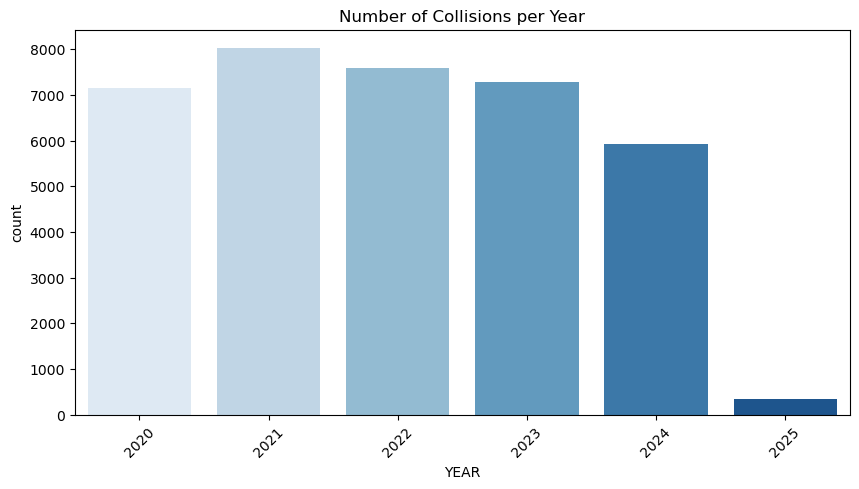

In [103]:
# Collisions Trends by Year
collisions_gdf_cleaned['YEAR'] = collisions_gdf_cleaned['INCDATE'].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(x=collisions_gdf_cleaned['YEAR'], palette="Blues")
plt.xticks(rotation=45)
plt.title("Number of Collisions per Year")
plt.show()


In [114]:
summary_by_year = collisions_gdf_cleaned.groupby('YEAR')[
    ['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
     'INJURIES', 'SERIOUSINJURIES', 'FATALITIES']
].sum()

summary_by_year

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
YEAR,,,,,,,
2020,15417,290,193,10607,2646,151,23
2021,17329,354,229,11634,2859,195,32
2022,16900,375,255,11806,2947,236,30
2023,15805,367,275,10458,3035,290,28
2024,12880,287,228,7902,2421,189,29
2025,677,0,0,0,140,0,1


## **Spatial Joins and Overlay Analysis**

How collisions relate to bike lanes, multi-use trails, and sidewalks 

In [121]:
# Collisions within 10 m for existing bike facilities 
collisions_near_bikes = gpd.sjoin_nearest(
    collisions_gdf_cleaned,
    bike_facilities_gdf_cleaned,
    how='left',
    max_distance=10,  # 10 meters
    distance_col='dist_to_bike' 
)
collisions_within_10m = collisions_near_bikes.dropna(subset=['dist_to_bike'])
print(f"Collisions truly within 10 meters: {collisions_within_10m.shape[0]}")

Collisions truly within 10 meters: 13290


In [122]:
# Collisions within 10 m for multi-use trails
collisions_near_multitrails = gpd.sjoin_nearest(
    collisions_gdf_cleaned,
    multi_use_trails_gdf_cleaned,
    how='left',
    max_distance=10,  # 10 meters
    distance_col='dist_to_trails' 
)
collisions_within_10m = collisions_near_multitrails.dropna(subset=['dist_to_trails'])
print(f"Collisions truly within 10 meters: {collisions_within_10m.shape[0]}")

Collisions truly within 10 meters: 781


In [123]:
# Collisions within 10 m for sidewalks 
collisions_near_sidewalks = gpd.sjoin_nearest(
    collisions_gdf_cleaned,
    sidewalks_gdf_cleaned,
    how='left',
    max_distance=10,  # 10 meters
    distance_col='dist_to_sidewalks' 
)
collisions_within_10m = collisions_near_sidewalks.dropna(subset=['dist_to_sidewalks'])
print(f"Collisions truly within 10 meters: {collisions_within_10m.shape[0]}")

Collisions truly within 10 meters: 27752


## **Save the cleaned data**

In [126]:
collisions_gdf_cleaned.to_file("/home/jovyan/seattle-micromobility/data/processed/seattle_collisions.geojson", driver="GeoJSON")
bike_facilities_gdf_cleaned.to_file("/home/jovyan/seattle-micromobility/data/processed/seattle_bike_facilities.geojson", driver="GeoJSON")
multi_use_trails_gdf_cleaned.to_file("/home/jovyan/seattle-micromobility/data/processed/seattle_multi_use_trails.geojson", driver="GeoJSON")
sidewalks_gdf_cleaned.to_file("/home/jovyan/seattle-micromobility/data/processed/seattle_sidewalks.geojson", driver="GeoJSON")